<a href="https://colab.research.google.com/github/h-razu/air-quality-analysis/blob/main/air_quality_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the Required Library

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

import warnings
warnings.filterwarnings('ignore')

## Task 01: Data Handling

#### Mount Google Drive and Load the Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/datasets/assessment_datasets'

/content/drive/MyDrive/datasets/assessment_datasets


In [ ]:
%ls

ada_boost_model.pkl
air_quality_data_combined.csv
app.py
combined_output.csv
home.py
modeling.py
PRSA_Data_Aotizhongxin_20130301-20170228.csv
PRSA_Data_Changping_20130301-20170228.csv
PRSA_Data_Dingling_20130301-20170228.csv
PRSA_Data_Dongsi_20130301-20170228.csv
PRSA_Data_Guanyuan_20130301-20170228.csv
PRSA_Data_Gucheng_20130301-20170228.csv
PRSA_Data_Huairou_20130301-20170228.csv
PRSA_Data_Nongzhanguan_20130301-20170228.csv
PRSA_Data_Shunyi_20130301-20170228.csv
PRSA_Data_Tiantan_20130301-20170228.csv
PRSA_Data_Wanliu_20130301-20170228.csv
PRSA_Data_Wanshouxigong_20130301-20170228.csv
__pycache__/
random_forest_model.pkl
summary.py
visualization.py
xgb_model.pkl


#### Randomly Select 5 Datasets and Merge them into One

In [ ]:
# Get all files in the folder
files = os.listdir()

# Filter only CSV files that start with "PRSA_Data_"
csv_files = [file for file in files if file.startswith("PRSA_Data_") and file.endswith(".csv")]

# Choose 5 random CSV files
random_csv_files = random.sample(csv_files, 5)
selected_stations = [csv_file.split('_')[2] for csv_file in random_csv_files]

# Read and combine random selected CSV files
combined_df = pd.concat([pd.read_csv(file) for file in random_csv_files], ignore_index=True)

# Save to a new CSV file
combined_df.to_csv("air_quality_data_combined.csv", index=False)

print(f"CSV files containing {selected_stations} station have been merged into 'air_quality_data_combined.csv'.")

CSV files containing ['Wanshouxigong', 'Dingling', 'Changping', 'Shunyi', 'Gucheng'] station have been merged into 'air_quality_data_combined.csv'.


#### Read the Merge Dataset

In [ ]:
df = pd.read_csv("air_quality_data_combined.csv")
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,9.0,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,WNW,2.0,Wanshouxigong
1,2,2013,3,1,1,11.0,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,WNW,4.4,Wanshouxigong
2,3,2013,3,1,2,8.0,8.0,NaN,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,WNW,4.7,Wanshouxigong
3,4,2013,3,1,3,8.0,8.0,3.0,16.0,NaN,NaN,-0.7,1023.5,-20.9,0.0,NW,2.6,Wanshouxigong
4,5,2013,3,1,4,8.0,8.0,3.0,NaN,300.0,36.0,-0.9,1024.1,-21.7,0.0,WNW,2.5,Wanshouxigong


## Task 02A: Data Understanding

In [ ]:
print(f"DataFrame shape is: {df.shape}")

DataFrame shape is: (175320, 18)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175320 entries, 0 to 175319
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       175320 non-null  int64  
 1   year     175320 non-null  int64  
 2   month    175320 non-null  int64  
 3   day      175320 non-null  int64  
 4   hour     175320 non-null  int64  
 5   PM2.5    171512 non-null  float64
 6   PM10     172669 non-null  float64
 7   SO2      171490 non-null  float64
 8   NO2      170632 non-null  float64
 9   CO       166911 non-null  float64
 10  O3       170206 non-null  float64
 11  TEMP     175093 non-null  float64
 12  PRES     175100 non-null  float64
 13  DEWP     175090 non-null  float64
 14  RAIN     175105 non-null  float64
 15  wd       174319 non-null  object 
 16  WSPM     175135 non-null  float64
 17  station  175320 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 24.1+ MB


In [ ]:
#print data types
df_types = pd.DataFrame([df.dtypes], columns=df.columns)
df_types

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object


In [ ]:
# check duplicate value
df.duplicated().sum()

np.int64(0)

In [ ]:
df['station'].value_counts()

,count
station,
Wanshouxigong,35064
Dingling,35064
Changping,35064
Shunyi,35064
Gucheng,35064


###### Missing Values Summary:

In [ ]:
missing_values = pd.DataFrame([df.isna().sum(), ((df.isna().sum() / len(df))*100).round(3)], columns=df.columns)
missing_values.index = ['Count', 'Percentage']
missing_values

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
Count,0.0,0.0,0.0,0.0,0.0,3808.000,2651.000,3830.000,4688.000,8409.000,5114.000,227.000,220.000,230.000,215.000,1001.000,185.000,0.0
Percentage,0.0,0.0,0.0,0.0,0.0,2.172,1.512,2.185,2.674,4.796,2.917,0.129,0.125,0.131,0.123,0.571,0.106,0.0


The dataset shows that most columns have very few missing values (around 5%), with the most notable being the CO column. Other columns like PM2.5, PM10, SO2, and NO2 also have small amounts of missing data, ranging from 1.6% to 2.4%.

###### Missing Values Summary by Station

In [ ]:
#station wise missing value percentage for each columns
df.groupby('station').apply(lambda g: g.isnull().mean() * 100).T.round(2).T

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
station,,,,,,,,,,,,,,,,,,
Changping,0.0,0.0,0.0,0.0,0.0,2.21,1.66,1.79,1.90,4.34,1.72,0.15,0.14,0.15,0.15,0.40,0.12,0.0
Dingling,0.0,0.0,0.0,0.0,0.0,2.22,1.87,2.08,3.52,5.74,3.46,0.15,0.14,0.15,0.15,0.40,0.12,0.0
Gucheng,0.0,0.0,0.0,0.0,0.0,1.84,1.09,1.45,1.91,4.00,2.08,0.15,0.14,0.15,0.12,0.45,0.12,0.0
Shunyi,0.0,0.0,0.0,0.0,0.0,2.60,1.56,3.70,3.89,6.21,4.25,0.15,0.15,0.15,0.15,1.38,0.13,0.0
Wanshouxigong,0.0,0.0,0.0,0.0,0.0,1.98,1.38,1.91,2.15,3.70,3.07,0.05,0.05,0.05,0.05,0.23,0.04,0.0


The dataset shows minimal missing values across all stations, with most columns like `year`, `month`, and `station` having no missing data. Air quality measurements such as `PM2.5`, `PM10`, and `SO2` exhibit small missing value percentages, ranging from 1.66% to 5.74%. The `CO` column has the highest missing value percentage among the air quality metrics. Missing data is sparse and scattered across the stations, with no significant gaps in any specific station.

###### Visualize missing data as a heatmap:

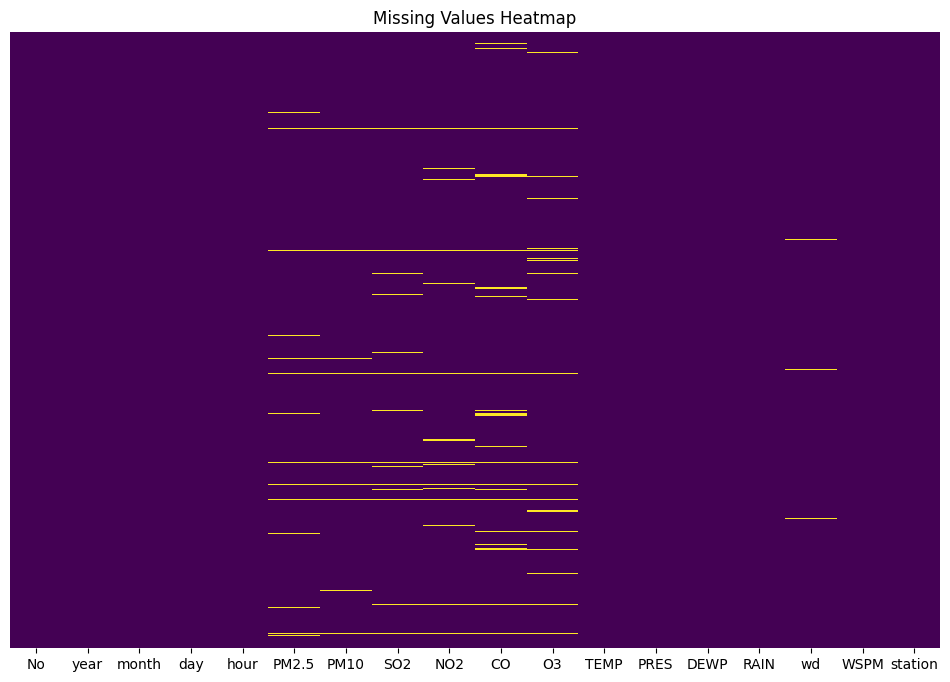

In [ ]:
# Visualize missing data as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

## Task 02B: Data Preprocessing

#### Handling Missing Values:

Since the percentage of missing values in the dataset is relatively low (around 5%), imputing missing values is a suitable approach. This will help preserve all available data and prevent the loss of valuable information by removing rows. Imputation ensures that the dataset remains complete, allowing for more accurate and reliable model training. By imputing, we avoid potential biases that could be introduced by dropping rows, ensuring the integrity of the analysis. Additionally, since I am using lag features for more accurate predictions in the random forest model, imputing the missing values will help maintain the consistency of the time series data for better forecasting performance.

In [ ]:
# Impute numerical columns with the mean
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Create an imputer for numerical data
numerical_imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the numerical columns
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

# Impute categorical columns with the mode (most frequent value)
categorical_cols = df.select_dtypes(include=['object']).columns

# Create an imputer for categorical data
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Apply the imputer to the categorical columns
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

I use `SimpleImputer(strategy='mean')` to replace missing values in numerical columns with the mean of each column, ensuring that the imputed values are consistent with the data distribution. For categorical columns, I use `SimpleImputer(strategy='most_frequent')` to fill missing values with the most frequent value (mode), preserving the most common category in the dataset.

###### Inspect missing values again:

In [ ]:
# Inspect missing values again
missing_values = pd.DataFrame([df.isna().sum(), ((df.isna().sum() / len(df))*100).round(3)], columns=df.columns)
missing_values.index = ['Count', 'Percentage']
missing_values

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
Count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Outliers Handling

###### Statistical Information

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No,175320.0,17532.500000,10122.133783,1.0000,8766.75,17532.5,26298.25,35064.0
year,175320.0,2014.662560,1.177200,2013.0000,2014.00,2015.0,2016.00,2017.0
month,175320.0,6.522930,3.448713,1.0000,4.00,7.0,10.00,12.0
day,175320.0,15.729637,8.800117,1.0000,8.00,16.0,23.00,31.0
hour,175320.0,11.500000,6.922206,0.0000,5.75,11.5,17.25,23.0
PM2.5,175320.0,77.098445,78.600568,2.0000,19.00,54.0,106.00,999.0
PM10,175320.0,101.677160,89.779578,2.0000,34.00,81.0,141.00,999.0
SO2,175320.0,14.564538,20.288811,0.2856,2.00,6.0,17.00,500.0
NO2,175320.0,45.475603,33.247828,1.0265,20.00,38.0,64.00,276.0
CO,175320.0,1188.903877,1109.734636,100.0000,500.00,900.0,1400.00,10000.0


###### Visualize Outiers

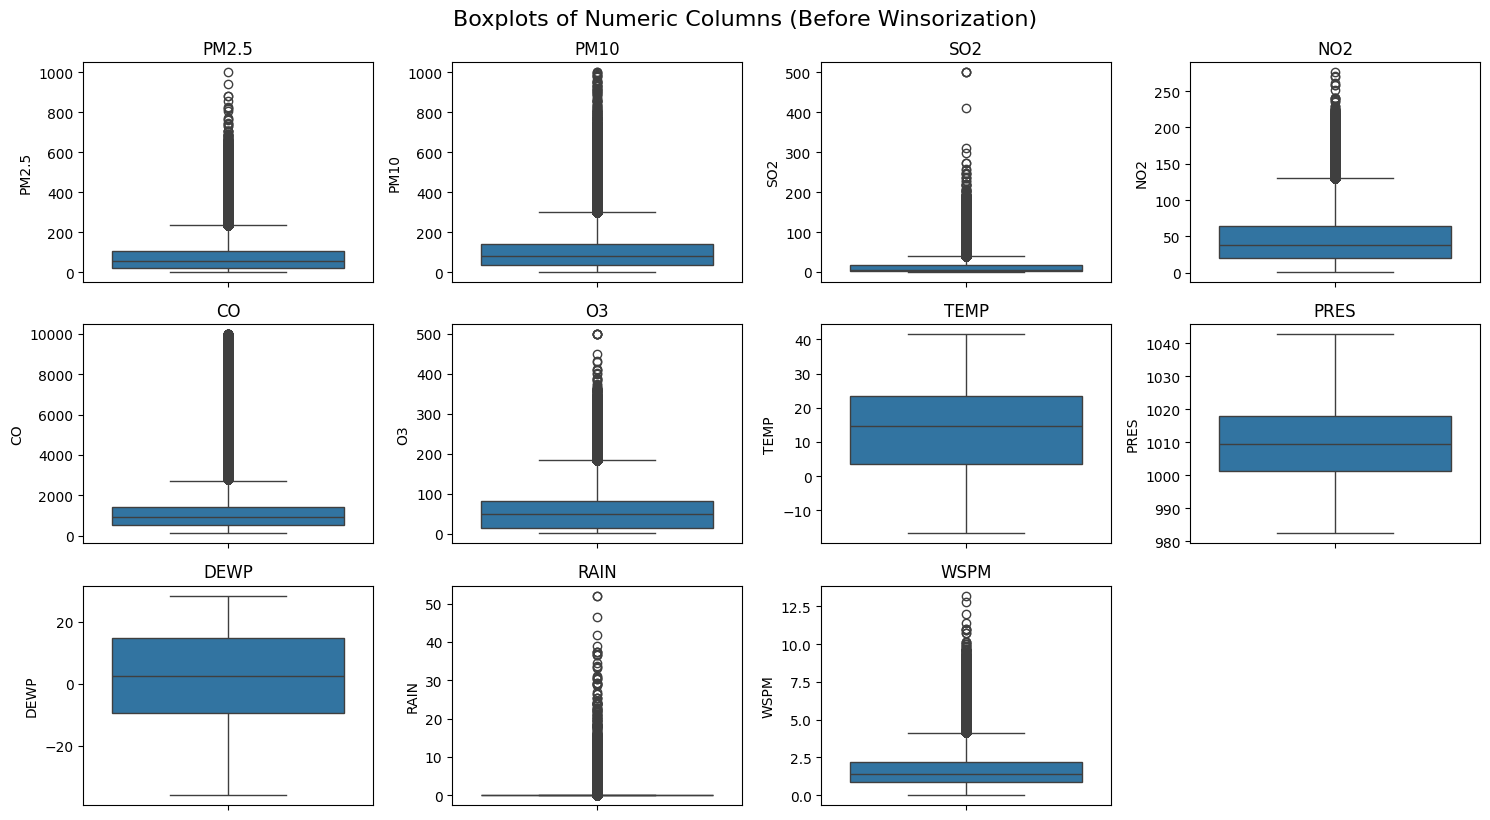

In [ ]:
# Select only numerical columns
numeric_cols = df.select_dtypes(include=['number']).columns.to_list()
numeric_cols.remove('No') # excluding `No` column
numeric_cols.remove('year') # excluding `year` column
numeric_cols.remove('month') # excluding `month` column
numeric_cols.remove('day') # excluding `day` column
numeric_cols.remove('hour') # excluding `hour` column

plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.suptitle('Boxplots of Numeric Columns (Before Winsorization)', fontsize=16, y=1.02)
plt.show()

| Column          | Observation                                                                                      |
|------------------|--------------------------------------------------------------------------------------------------|
| **PM2.5**        | Many extreme outliers above 200 µg/m³, but still plausible in highly polluted areas.            |
| **PM10**         | Similar to PM2.5, lots of upper outliers; real-world events (e.g., dust storms) can explain these. |
| **SO2**          | Several upper outliers; SO₂ spikes can occur near industrial zones.                              |
| **NO2**          | Noticeable number of upper outliers; again possibly from traffic/urban activity.                |
| **CO**           | Very large outliers reaching 10,000; likely sensor error. |
| **O3**           | Some high outliers; ozone levels can peak midday but values seem extreme.                       |
| **TEMP, PRES, DEWP** | Distributions are clean with minimal or no outliers—no need for removal.                      |
| **RAIN**         | Some spikes—likely rare but valid rainfall events. Could be left in.                            |
| **WSPM**         | Wind speed has a few outliers but they appear within a reasonable range.                        |

###### IQR-Based Winsorization

In [ ]:
# for col in numeric_cols:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)

In [ ]:
# plt.figure(figsize=(15, 8))
# for i, col in enumerate(numeric_cols, 1):
#     plt.subplot(3, 4, i)
#     sns.boxplot(y=df[col])
#     plt.title(col)
# plt.tight_layout()
# plt.show()

###### Percentile-Based Winsorization

Percentile-based winsorization caps the extreme values by replacing those below the 1st percentile and above the 99th percentile, making it suitable for skewed data like pollution and weather measurements. It preserves the overall dataset while reducing the influence of outliers that may distort analysis or model performance. In contrast, the IQR method uses the 25th and 75th percentiles to define a range and caps values outside of 1.5 times the IQR, which works better for normally distributed data. For environmental datasets, percentile-based capping is preferred because it’s more tolerant of natural but extreme fluctuations. It also helps maintain the data's integrity while improving stability in visualization and modeling.

In [ ]:
# Winsorization (1st and 99th percentiles)
for col in numeric_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=lower, upper=upper)

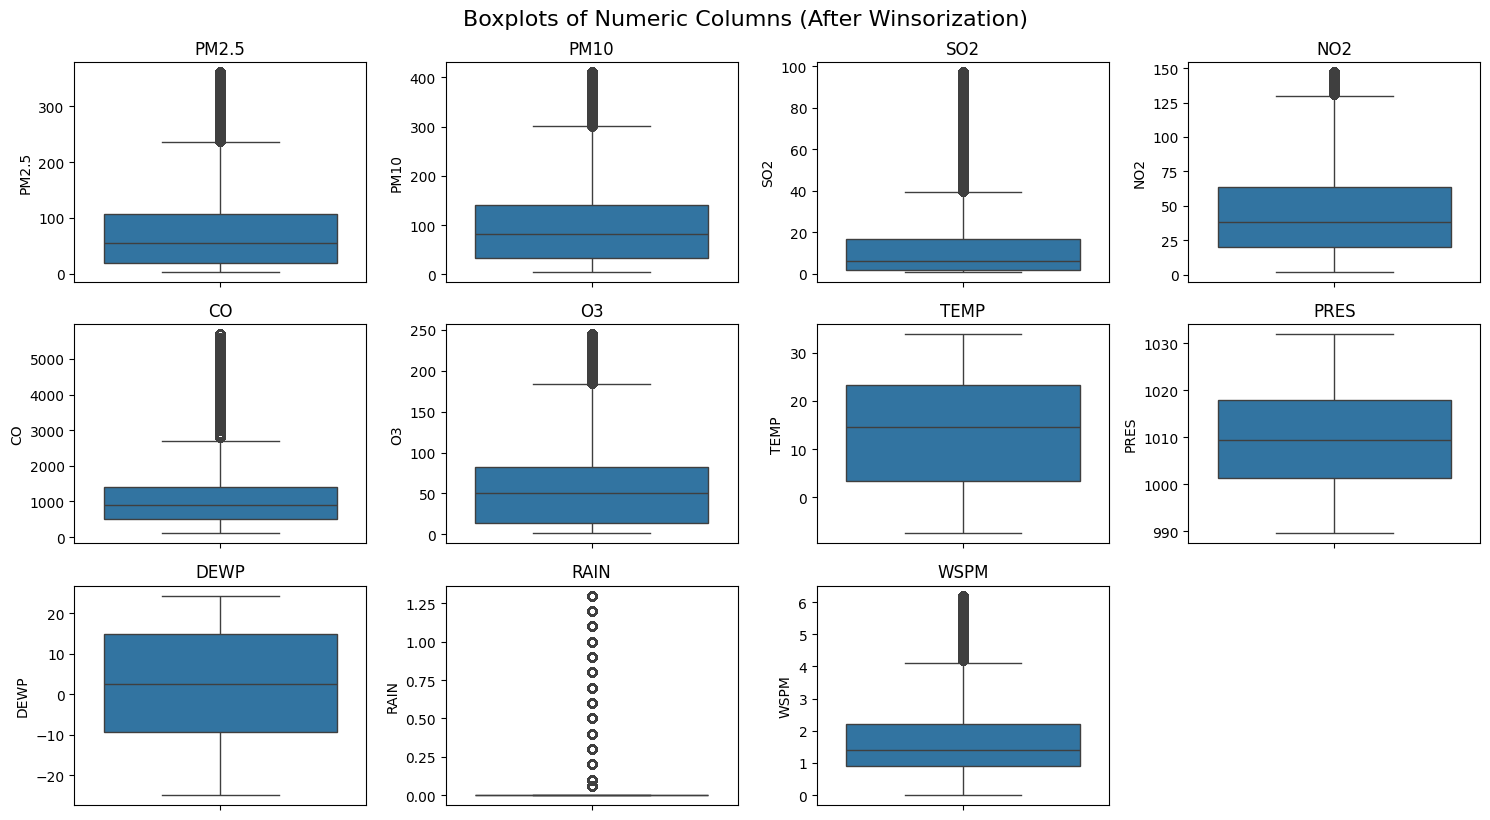

In [ ]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.suptitle('Boxplots of Numeric Columns (After Winsorization)', fontsize=16, y=1.02)
plt.show()

#### Feature Extraction

###### Merge `year`, `month`, `day`, `hour` into `timestamp`. Convert it into datetime and set as index.

Converting the `year`, `month`, `day`, and `hour` into a datetime `timestamp` and using it as the index simplifies the data structure and enhances analysis. It allows for efficient time-based operations like filtering, resampling, and time series analysis. Storing the data as datetime reduces memory usage and ensures consistency, making it easier to work with time-related calculations. Using it as the index also helps in sorting and accessing data by specific time intervals, improving the overall efficiency of time-based analyses and visualizations.

In [ ]:
# Create `timestamp` column
df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Set `timestamp` as the index
df = df.set_index('timestamp')

# Drop `No`, `day`, `hour`
df = df.drop(['No', 'day', 'hour'], axis=1)

df.head()

,year,month,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
timestamp,,,,,,,,,,,,,,,
2013-03-01 00:00:00,2013.0,3.0,9.0,9.0,6.000000,17.000000,200.000000,62.000000,0.3,1021.9,-19.0,0.0,WNW,2.0,Wanshouxigong
2013-03-01 01:00:00,2013.0,3.0,11.0,11.0,7.000000,14.000000,200.000000,66.000000,-0.1,1022.4,-19.3,0.0,WNW,4.4,Wanshouxigong
2013-03-01 02:00:00,2013.0,3.0,8.0,8.0,14.564538,16.000000,200.000000,59.000000,-0.6,1022.6,-19.7,0.0,WNW,4.7,Wanshouxigong
2013-03-01 03:00:00,2013.0,3.0,8.0,8.0,3.000000,16.000000,1188.903877,59.118611,-0.7,1023.5,-20.9,0.0,NW,2.6,Wanshouxigong
2013-03-01 04:00:00,2013.0,3.0,8.0,8.0,3.000000,45.475603,300.000000,36.000000,-0.9,1024.1,-21.7,0.0,WNW,2.5,Wanshouxigong


###### Calculate AQI (air quality index)

The Air Quality Index (AQI) is calculated by measuring the concentration of pollutants like ozone, particulate matter, sulfur dioxide, nitrogen dioxide, and carbon monoxide, then determining the highest sub-index value among these pollutants, which becomes the overall AQI.
[AQI on Wikipedia](https://en.wikipedia.org/wiki/Air_quality_index)

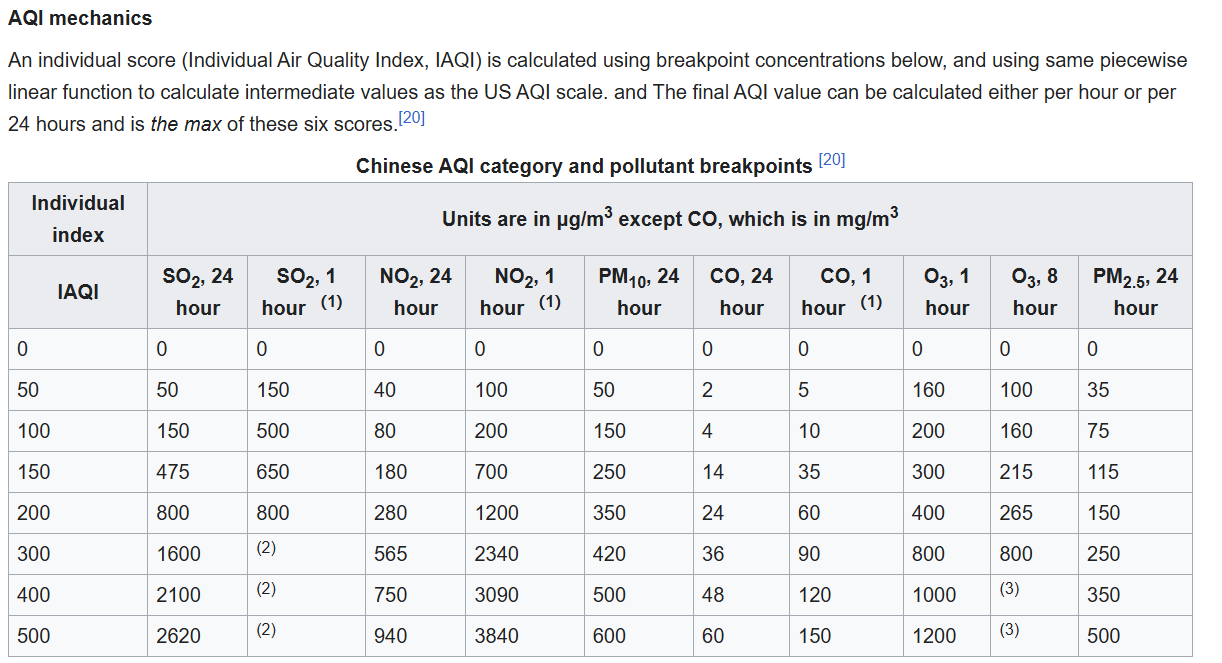

In [ ]:
# breakpoint for calculating AQI for each one
breakpoints_pm25_per_day = [(0, 35, 0, 50), (35, 75, 51, 100), (75, 115, 101, 150), (115, 150, 151, 200),
                    (150, 250, 201, 300), (250, 350, 301, 400), (350, 500, 401, 500)]

breakpoints_pm10_per_day = [(0, 50, 0, 50), (51, 150, 51, 100), (151, 250, 101, 150), (251, 350, 151, 200),
                    (350, 420, 201, 300), (420, 500, 301, 400), (500, 600, 401, 500)]

breakpoints_so2_per_hour = [(0, 150, 0, 50), (151, 500, 51, 100), (501, 650, 101, 150), (651, 800, 151, 200),
                   (801, 1600, 201, 300), (1601, 2100, 301, 400), (2100, 2620, 401, 500)]

breakpoints_no2_per_hour = [(0, 100, 0, 50), (101, 200, 51, 100), (201, 700, 101, 150), (701, 1200, 151, 200),
                   (1201, 2340, 201, 300), (2341, 3090, 301, 400), (3091, 3840, 401, 500)]

breakpoints_co_per_hour = [(0, 5000, 0, 50), (5001, 10000, 51, 100), (10001, 35000, 101, 150), (35001, 60000, 151, 200),
                  (60001, 90000, 201, 300), (90001, 120000, 301, 400), (120001, 150000, 401, 500)]

breakpoints_o3_per_hour = [(0, 160, 0, 50), (161, 200, 51, 100), (201, 300, 101, 150), (301, 400, 151, 200),
                  (401, 800, 201, 300), (801, 1000, 301, 400), (1001, 1200, 401, 500)]

The Air Quality Index (AQI) is calculated using a formula that converts measured pollutant concentrations into a single index value, with the highest sub-index value determining the overall AQI.



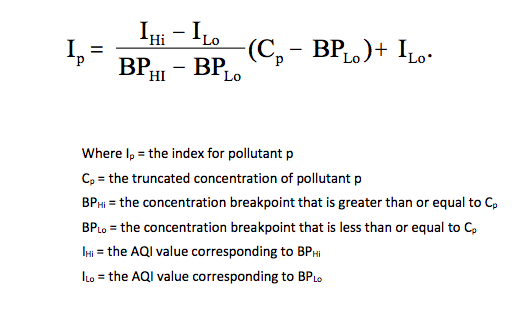

In [ ]:
def calculate_aqi(conc, breakpoints):
    for C_low, C_high, I_low, I_high in breakpoints:
        if C_low <= conc <= C_high:
            return ((I_high - I_low) / (C_high - C_low)) * (conc - C_low) + I_low
    return np.nan

# 24-hour averages for PM2.5 and PM10
df['PM2.5_24h'] = df['PM2.5'].rolling(window=24, min_periods=1).mean()
df['PM10_24h'] = df['PM10'].rolling(window=24, min_periods=1).mean()

# AQI per pollutant
df['AQI_PM25'] = df['PM2.5_24h'].apply(lambda x: calculate_aqi(x, breakpoints_pm25_per_day))
df['AQI_PM10'] = df['PM10_24h'].apply(lambda x: calculate_aqi(x, breakpoints_pm10_per_day))
df['AQI_SO2'] = df['SO2'].apply(lambda x: calculate_aqi(x, breakpoints_so2_per_hour))
df['AQI_NO2'] = df['NO2'].apply(lambda x: calculate_aqi(x, breakpoints_no2_per_hour))
df['AQI_CO'] = df['CO'].apply(lambda x: calculate_aqi(x, breakpoints_co_per_hour))
df['AQI_O3'] = df['O3'].apply(lambda x: calculate_aqi(x, breakpoints_o3_per_hour))

# Final AQI: max value among all pollutants
df['AQI'] = df[['AQI_PM25', 'AQI_PM10', 'AQI_SO2', 'AQI_NO2', 'AQI_CO', 'AQI_O3']].max(axis=1).round()

df[['AQI_PM25', 'AQI_PM10', 'AQI_SO2', 'AQI_NO2', 'AQI_CO', 'AQI_O3', 'AQI']].head()

,AQI_PM25,AQI_PM10,AQI_SO2,AQI_NO2,AQI_CO,AQI_O3,AQI
timestamp,,,,,,,
2013-03-01 00:00:00,12.857143,9.000000,2.000000,8.500000,2.000000,19.375000,19.0
2013-03-01 01:00:00,14.285714,10.000000,2.333333,7.000000,2.000000,20.625000,21.0
2013-03-01 02:00:00,13.333333,9.333333,4.854846,8.000000,2.000000,18.437500,18.0
2013-03-01 03:00:00,12.857143,9.000000,1.000000,8.000000,11.889039,18.474566,18.0
2013-03-01 04:00:00,12.571429,8.800000,1.000000,22.737801,3.000000,11.250000,23.0


In [ ]:
# Keeping only `AQI` column, droping other column related to calculating AQI
df.drop(['PM2.5_24h', 'PM10_24h', 'AQI_PM25', 'AQI_PM10', 'AQI_SO2', 'AQI_NO2', 'AQI_CO', 'AQI_O3'], axis=1, inplace=True)

df.head()

,year,month,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,AQI
timestamp,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,2013.0,3.0,9.0,9.0,6.000000,17.000000,200.000000,62.000000,0.3,1021.9,-19.0,0.0,WNW,2.0,Wanshouxigong,19.0
2013-03-01 01:00:00,2013.0,3.0,11.0,11.0,7.000000,14.000000,200.000000,66.000000,-0.1,1022.4,-19.3,0.0,WNW,4.4,Wanshouxigong,21.0
2013-03-01 02:00:00,2013.0,3.0,8.0,8.0,14.564538,16.000000,200.000000,59.000000,-0.6,1022.6,-19.7,0.0,WNW,4.7,Wanshouxigong,18.0
2013-03-01 03:00:00,2013.0,3.0,8.0,8.0,3.000000,16.000000,1188.903877,59.118611,-0.7,1023.5,-20.9,0.0,NW,2.6,Wanshouxigong,18.0
2013-03-01 04:00:00,2013.0,3.0,8.0,8.0,3.000000,45.475603,300.000000,36.000000,-0.9,1024.1,-21.7,0.0,WNW,2.5,Wanshouxigong,23.0


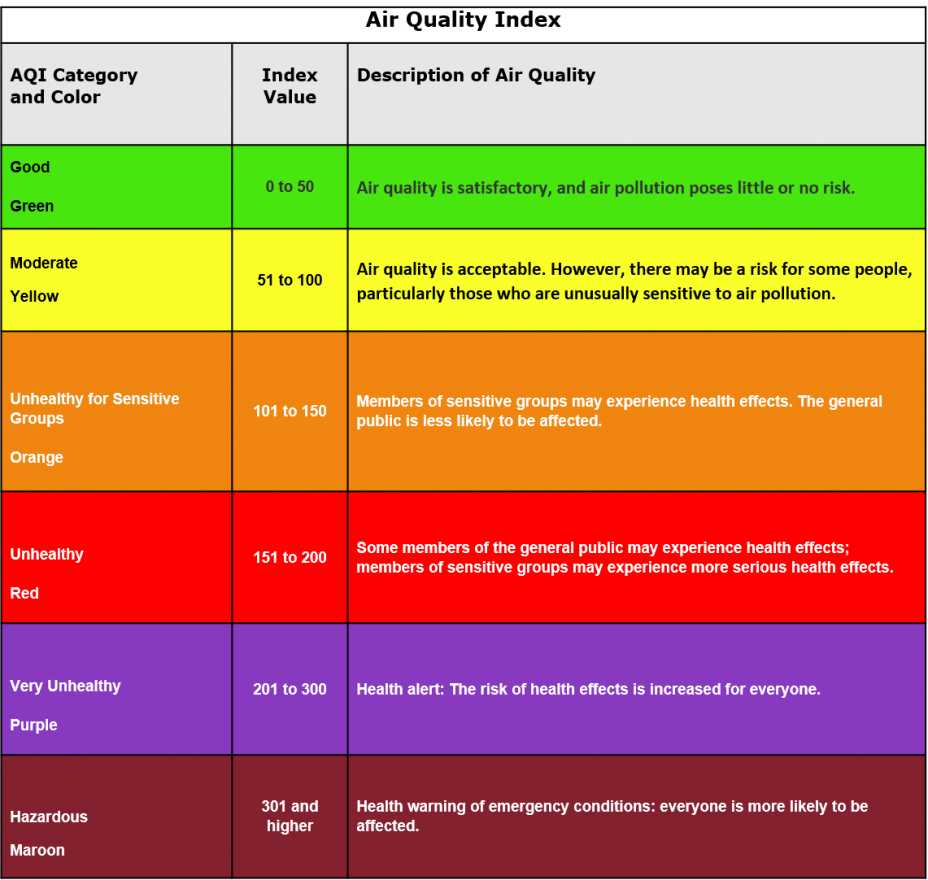

In [ ]:
# create `AQI_category` column
bins = [0, 50, 100, 150, 200, 300, float('inf')]
labels = ['Good', 'Moderate', 'Unhealthy for sensitive group', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

df['AQI_category'] = pd.cut(df['AQI'], bins=bins, labels=labels, right=False)

df.head()

,year,month,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,AQI,AQI_category
timestamp,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,2013.0,3.0,9.0,9.0,6.000000,17.000000,200.000000,62.000000,0.3,1021.9,-19.0,0.0,WNW,2.0,Wanshouxigong,19.0,Good
2013-03-01 01:00:00,2013.0,3.0,11.0,11.0,7.000000,14.000000,200.000000,66.000000,-0.1,1022.4,-19.3,0.0,WNW,4.4,Wanshouxigong,21.0,Good
2013-03-01 02:00:00,2013.0,3.0,8.0,8.0,14.564538,16.000000,200.000000,59.000000,-0.6,1022.6,-19.7,0.0,WNW,4.7,Wanshouxigong,18.0,Good
2013-03-01 03:00:00,2013.0,3.0,8.0,8.0,3.000000,16.000000,1188.903877,59.118611,-0.7,1023.5,-20.9,0.0,NW,2.6,Wanshouxigong,18.0,Good
2013-03-01 04:00:00,2013.0,3.0,8.0,8.0,3.000000,45.475603,300.000000,36.000000,-0.9,1024.1,-21.7,0.0,WNW,2.5,Wanshouxigong,23.0,Good


###### Calculate `vehicle_pollution` and `industrial_pollution`

Summing specific pollutants to create `vehicle_pollution` and `industrial_pollution` variables is a practical approach to quantify pollution from these sources. `Vehicle_pollution` combines `PM2.5`, `PM10`, `NO2`, and `CO`, while `industrial_pollution` sums `SO2` and `O3`. This aggregation simplifies complex data, aiding in the analysis of trends and the development of targeted policies. However, the method assumes equal contribution from each pollutant within a category and requires consistent units.

In [ ]:
df['vehicle_pollution'] = df[['PM2.5', 'PM10', 'NO2', 'CO']].sum(axis=1)
df['industrial_pollution'] = df[['SO2', 'O3']].sum(axis=1)

df.head()

,year,month,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,AQI,AQI_category,vehicle_pollution,industrial_pollution
timestamp,,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,2013.0,3.0,9.0,9.0,6.000000,17.000000,200.000000,62.000000,0.3,1021.9,-19.0,0.0,WNW,2.0,Wanshouxigong,19.0,Good,235.000000,68.000000
2013-03-01 01:00:00,2013.0,3.0,11.0,11.0,7.000000,14.000000,200.000000,66.000000,-0.1,1022.4,-19.3,0.0,WNW,4.4,Wanshouxigong,21.0,Good,236.000000,73.000000
2013-03-01 02:00:00,2013.0,3.0,8.0,8.0,14.564538,16.000000,200.000000,59.000000,-0.6,1022.6,-19.7,0.0,WNW,4.7,Wanshouxigong,18.0,Good,232.000000,73.564538
2013-03-01 03:00:00,2013.0,3.0,8.0,8.0,3.000000,16.000000,1188.903877,59.118611,-0.7,1023.5,-20.9,0.0,NW,2.6,Wanshouxigong,18.0,Good,1220.903877,62.118611
2013-03-01 04:00:00,2013.0,3.0,8.0,8.0,3.000000,45.475603,300.000000,36.000000,-0.9,1024.1,-21.7,0.0,WNW,2.5,Wanshouxigong,23.0,Good,361.475603,39.000000


## Task 02C: Analysis and Visualizations

#### Average AQI per Year

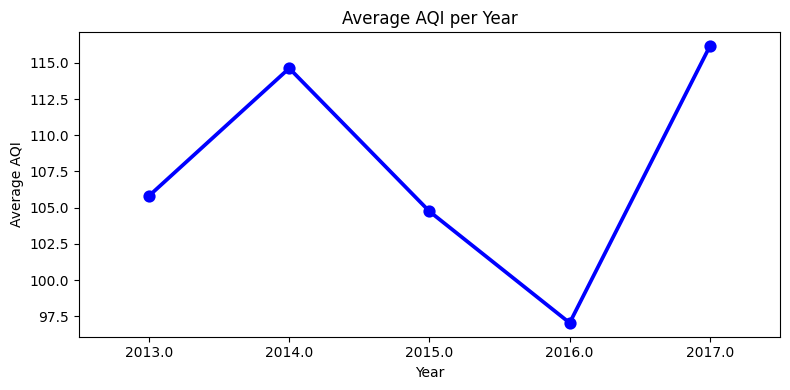

In [ ]:
# Group by year and calculate mean AQI
yearly_avg = df.groupby('year')['AQI'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.pointplot(x='year', y='AQI', data=yearly_avg, color='blue', markers='o', linestyles='-')
plt.title('Average AQI per Year')
plt.ylabel('Average AQI')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

In 2013, the AQI started at a moderate level around 106, followed by a noticeable increase in 2014, reaching approximately 115, indicating deteriorating air quality. From 2014 to 2016, there was a gradual improvement as the AQI consistently decreased, hitting its lowest point of about 97 in 2016. However, this improvement did not sustain, as 2017 saw a sharp rise in AQI levels back to around 116. Overall, the pattern highlights short-term improvements in air quality rather than a steady long-term decline in pollution.

#### Average AQI per Year for each Station

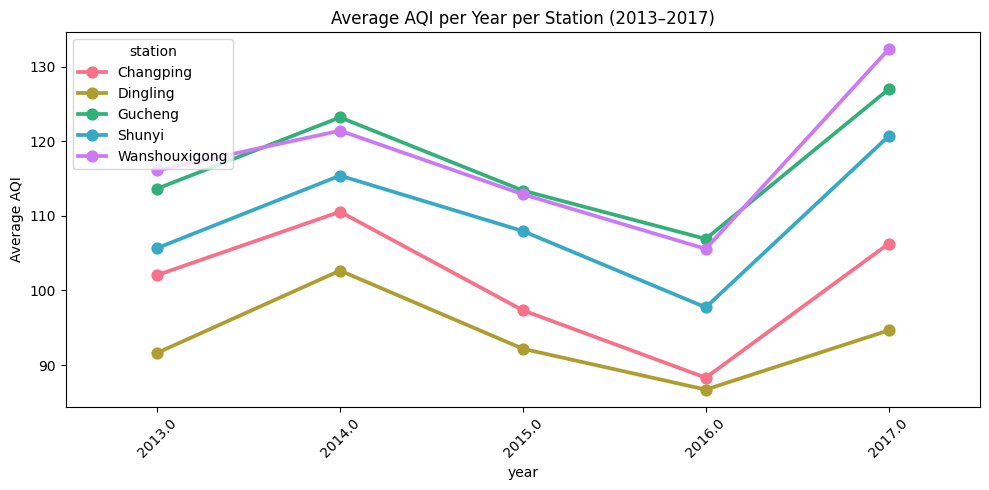

In [ ]:
yearly_avg_by_station = df.groupby(['year', 'station'])['AQI'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.pointplot(data=yearly_avg_by_station, x='year', y='AQI', hue='station', palette='husl', linestyles='-')
plt.title('Average AQI per Year per Station (2013–2017)')
plt.ylabel('Average AQI')
plt.xlabel('year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most stations, including Changping, Gucheng, Shunyi, and Wanshouxigong, experienced a rise in AQI from 2013 to 2014, indicating worsening air quality. From 2014 to 2016, AQI values generally declined across all stations, suggesting some improvement in pollution levels. However, in 2017, there was a sharp increase in AQI at all stations, with Wanshouxigong and Gucheng showing the highest levels. Overall, while some short-term progress was seen, the final year shows a significant setback in air quality improvements.

#### Average Monthly AQI per Year (2013–2017)

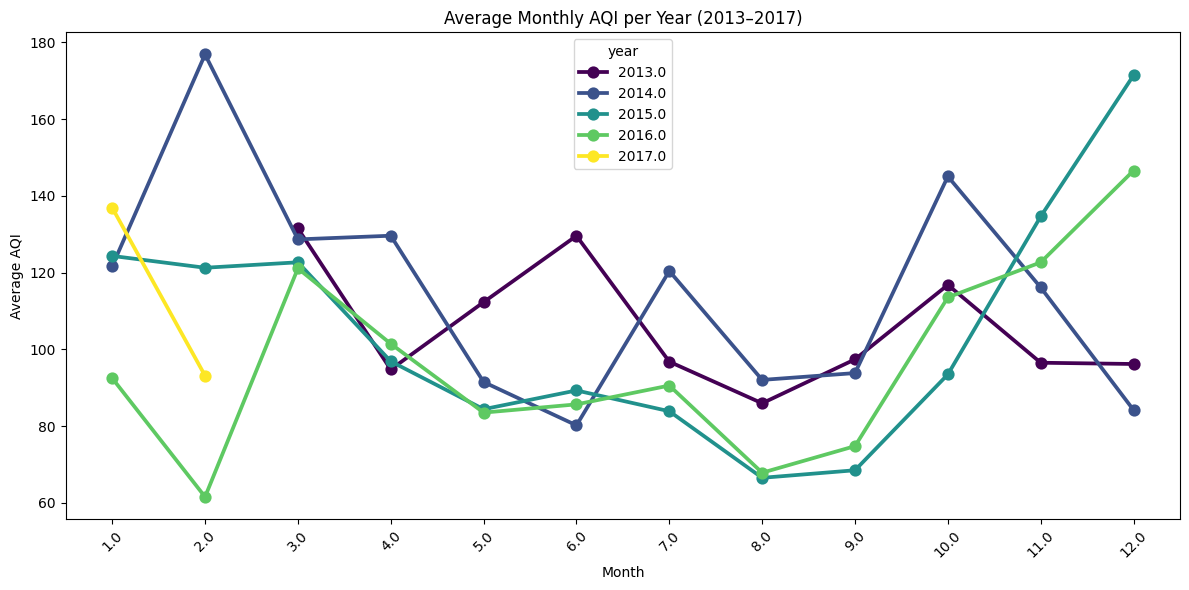

In [ ]:
monthly_yearly_avg = df.groupby(['year', 'month'])['AQI'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.pointplot(data=monthly_yearly_avg, x='month', y='AQI', hue='year', palette='viridis', linestyles='-')
plt.title('Average Monthly AQI per Year (2013–2017)')
plt.ylabel('Average AQI')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

AQI levels are higher during the winter months (January to March and November to December) and lower in the summer months (June to August). The year 2014 shows especially high peaks early in the year compared to other years. Although there are fluctuations year by year, the seasonal pattern of higher pollution in colder months is clearly visible. This suggests that air quality tends to worsen during winter, likely due to increased heating activities and stagnant weather conditions.

#### Yearly Average Pollution Trend

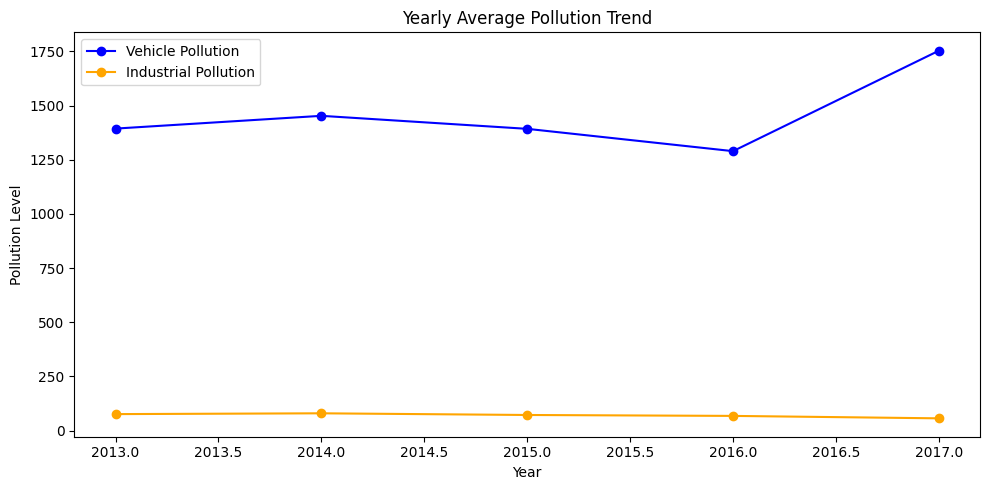

In [ ]:
yearly_avg = df.groupby('year')[['vehicle_pollution', 'industrial_pollution']].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(yearly_avg['year'], yearly_avg['vehicle_pollution'], marker='o', label='Vehicle Pollution', color='blue')
plt.plot(yearly_avg['year'], yearly_avg['industrial_pollution'], marker='o', label='Industrial Pollution', color='orange')
plt.title('Yearly Average Pollution Trend')
plt.xlabel('Year')
plt.ylabel('Pollution Level')
plt.legend()
plt.tight_layout()
plt.show()

The graph shows the yearly average pollution trends for vehicle and industrial sources from 2013 to 2017. Vehicle pollution levels are significantly higher compared to industrial pollution throughout the period. While vehicle pollution slightly increased from 2013 to 2014, it then declined until 2016 before sharply rising in 2017. Industrial pollution, on the other hand, remained relatively stable with a slight decreasing trend over the years. Overall, the graph highlights that vehicle pollution had greater fluctuations, while industrial pollution stayed relatively constant.

#### Seasonal Pollution Pattern (Monthly Average)

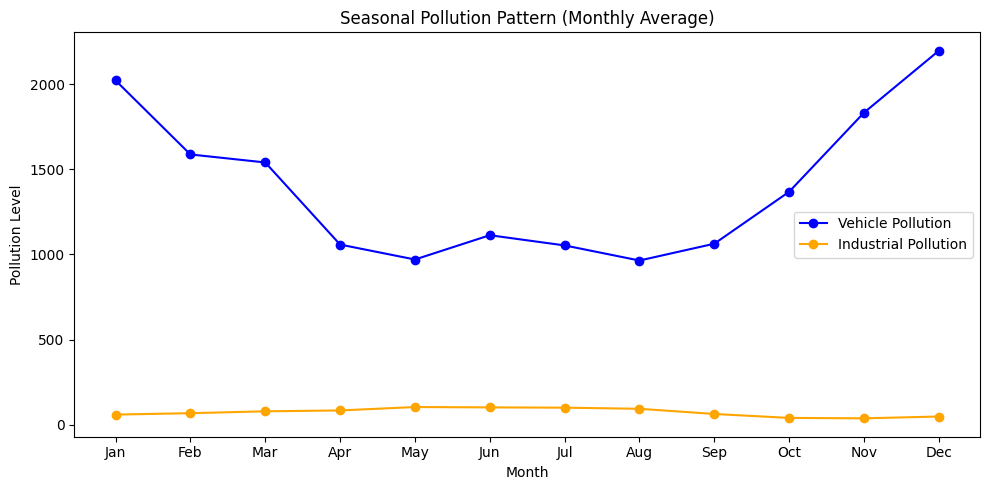

In [ ]:
monthly_seasonal = df.groupby('month')[['vehicle_pollution', 'industrial_pollution']].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(monthly_seasonal['month'], monthly_seasonal['vehicle_pollution'], marker='o', label='Vehicle Pollution', color='blue')
plt.plot(monthly_seasonal['month'], monthly_seasonal['industrial_pollution'], marker='o', label='Industrial Pollution', color='orange')
plt.title('Seasonal Pollution Pattern (Monthly Average)')
plt.xlabel('Month')
plt.ylabel('Pollution Level')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.tight_layout()
plt.show()

The graph illustrates the seasonal pollution pattern, showing monthly averages for vehicle and industrial pollution. Vehicle pollution is highest during the winter months, particularly in January and December, and lowest during the summer months like May and August. Industrial pollution remains relatively stable throughout the year with only slight fluctuations, peaking around May and June. A sharp rise in vehicle pollution is observed from September onwards, suggesting seasonal influences like increased vehicle use in colder months. Overall, the data highlights a stronger seasonal effect on vehicle pollution compared to industrial pollution.

#### Vehicle vs Industrial Pollution Contribution by Year

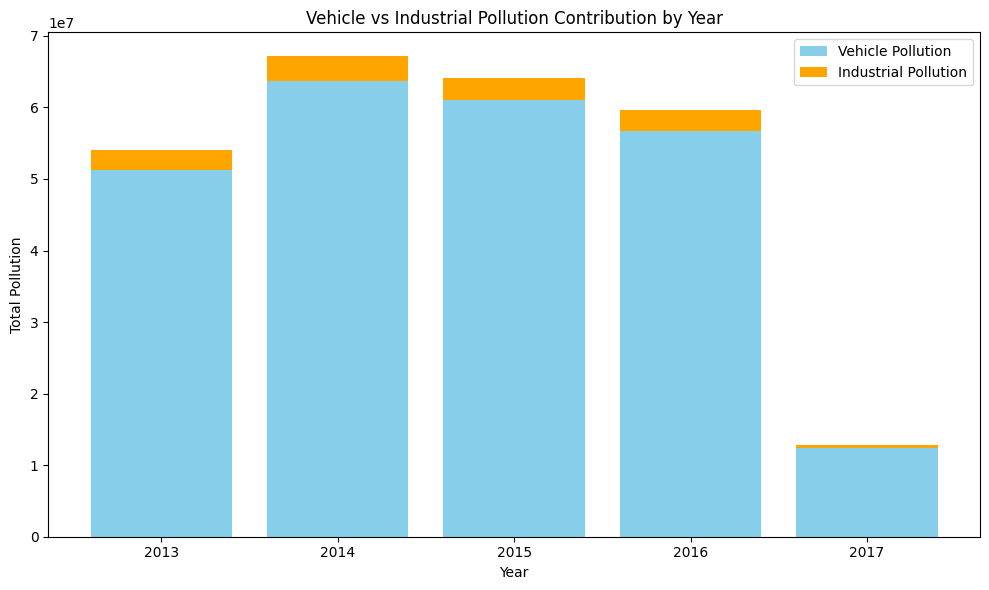

In [ ]:
yearly_pollution = df.groupby('year')[['vehicle_pollution', 'industrial_pollution']].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(yearly_pollution['year'], yearly_pollution['vehicle_pollution'], label='Vehicle Pollution', color='skyblue')
plt.bar(yearly_pollution['year'], yearly_pollution['industrial_pollution'],
        bottom=yearly_pollution['vehicle_pollution'], label='Industrial Pollution', color='orange')

plt.title('Vehicle vs Industrial Pollution Contribution by Year')
plt.xlabel('Year')
plt.ylabel('Total Pollution')
plt.legend()
plt.tight_layout()
plt.show()

The bar chart compares the yearly contributions of vehicle and industrial pollution from 2013 to 2017. Vehicle pollution consistently makes up the major portion of total pollution each year, while industrial pollution forms only a small fraction. The highest total pollution levels occurred in 2014, followed by slight decreases in 2015 and 2016. In 2017, there was a sharp drop in total pollution from both vehicle and industrial sources. Overall, the data clearly indicates that vehicles are the dominant contributors to pollution compared to industries over these years.

#### Pollution Type Contribution by Station and Year

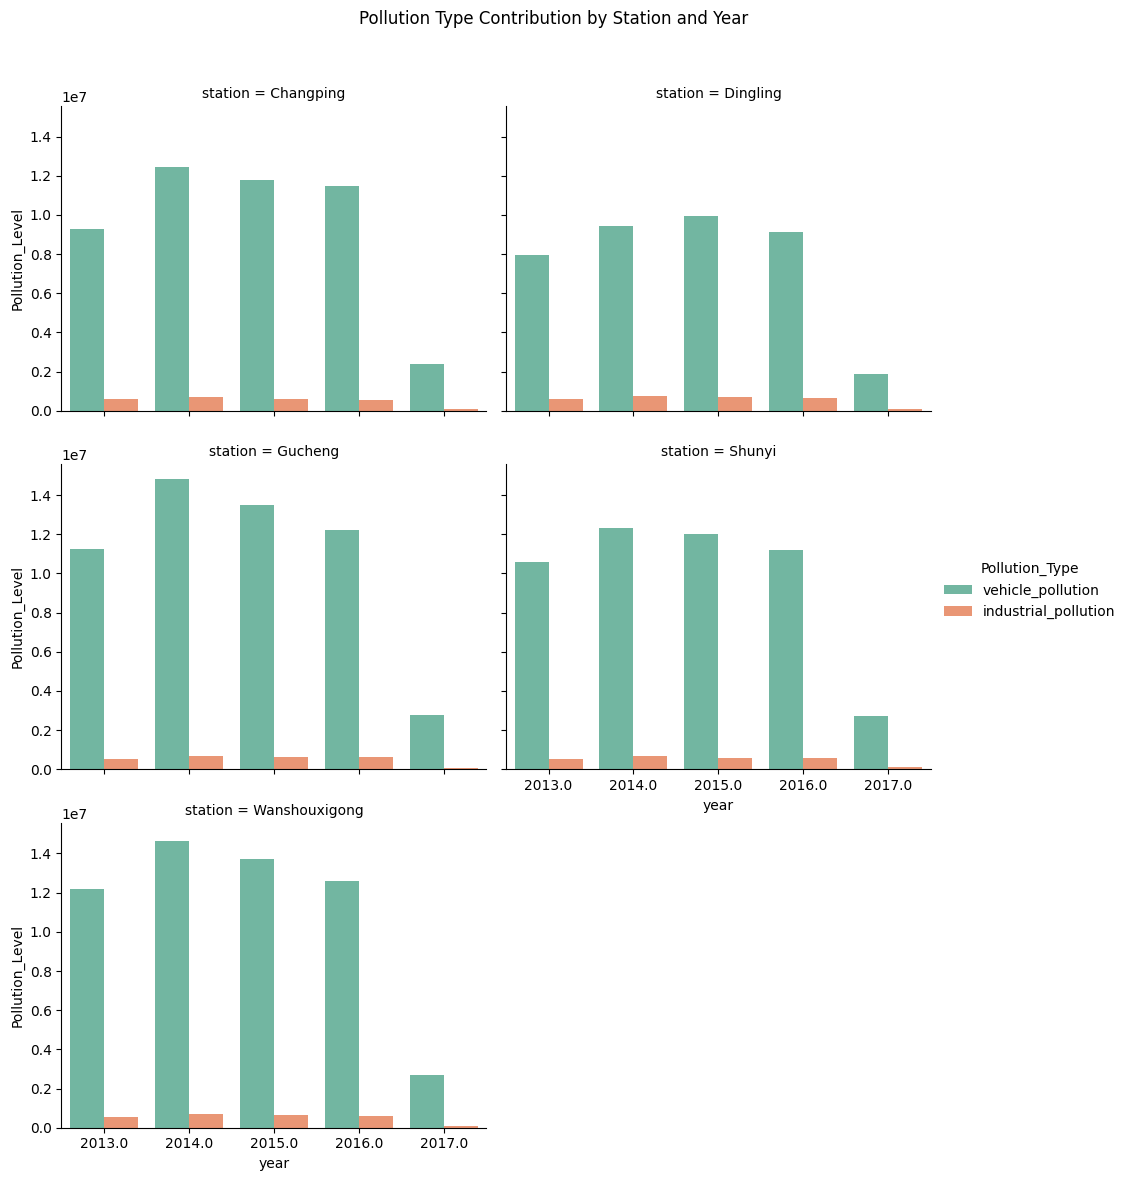

In [ ]:
pollution_by_station_year = df.groupby(['station', 'year'])[['vehicle_pollution', 'industrial_pollution']].sum().reset_index()

df_melted = pollution_by_station_year.melt(
    id_vars=['station', 'year'],
    value_vars=['vehicle_pollution', 'industrial_pollution'],
    var_name='Pollution_Type',
    value_name='Pollution_Level'
)

g = sns.catplot(
    data=df_melted,
    x='year', y='Pollution_Level',
    hue='Pollution_Type',
    col='station',
    kind='bar',
    col_wrap=2,
    height=4,
    aspect=1.2,
    palette='Set2'
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Pollution Type Contribution by Station and Year')
plt.show()

This graph illustrates the yearly contribution of vehicle and industrial pollution at five monitoring stations from 2013 to 2017. Across all stations, vehicle pollution consistently dominates industrial pollution in magnitude. Most stations show relatively stable vehicle pollution levels through the years, with a noticeable decline in 2017. Industrial pollution remains significantly lower and more stable across all years. The sharp drop in both pollution types in 2017 may indicate either data incompleteness or effective intervention measures during that year.

#### RAIN impact on AQI

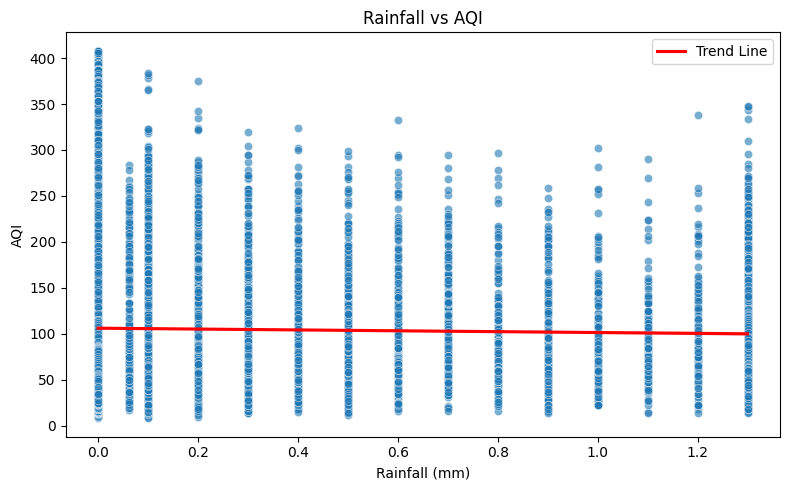

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='RAIN', y='AQI', alpha=0.6)
sns.regplot(data=df, x='RAIN', y='AQI', scatter=False, color='red', label='Trend Line')
plt.title('Rainfall vs AQI')
plt.xlabel('Rainfall (mm)')
plt.ylabel('AQI')
plt.legend()
plt.tight_layout()
plt.show()


This scatter plot displays the relationship between rainfall (in mm) and the Air Quality Index (AQI). Most AQI values are spread across all rainfall levels, indicating a weak or unclear correlation. The red trend line is nearly horizontal, suggesting that rainfall has little to no direct linear effect on AQI in this dataset. While heavier rain is generally expected to reduce air pollution, the data here does not show a strong decreasing pattern. This implies that other factors may play a more dominant role in AQI variation than rainfall alone.

#### RAIN vs Pollution Comparison

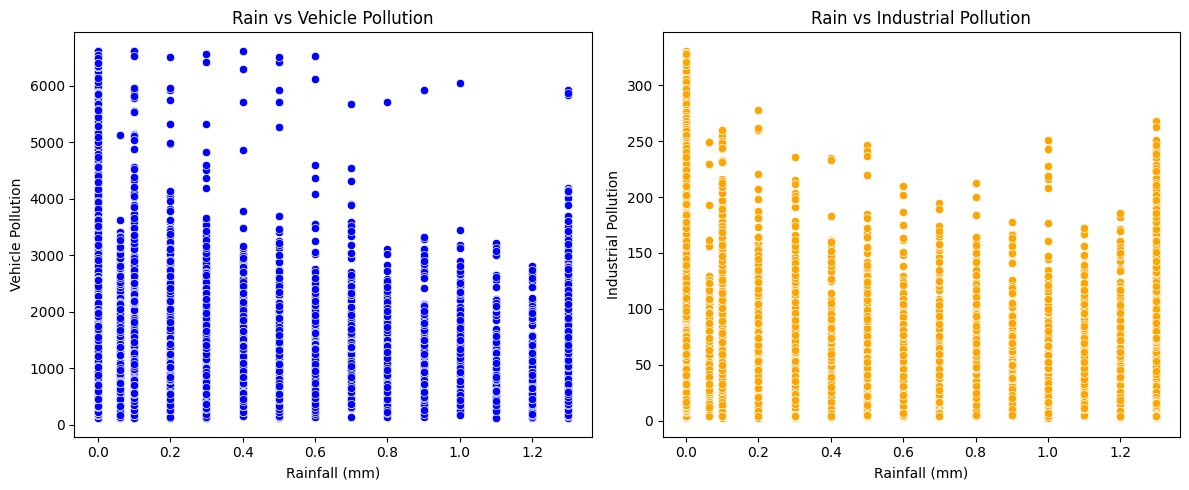

In [ ]:
plt.figure(figsize=(12, 5))

# Vehicle pollution
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='RAIN', y='vehicle_pollution', color='blue')
plt.title('Rain vs Vehicle Pollution')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Vehicle Pollution')

# Industrial pollution
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='RAIN', y='industrial_pollution', color='orange')
plt.title('Rain vs Industrial Pollution')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Industrial Pollution')

plt.tight_layout()
plt.show()


These scatter plots examine how rainfall relates to vehicle and industrial pollution levels. In the left plot, higher levels of vehicle pollution generally appear when rainfall is low, and pollution tends to decrease as rainfall increases. This suggests that rainfall may help reduce pollution from vehicles, likely by washing particulates from the air. On the right plot, industrial pollution also shows a slight downward trend with increasing rainfall, but the relationship is less distinct than with vehicle pollution. Overall, rainfall seems to have a more noticeable impact on vehicle-related pollution than industrial emissions.

#### Seasonal Patterns of Temperature and Dewpoint

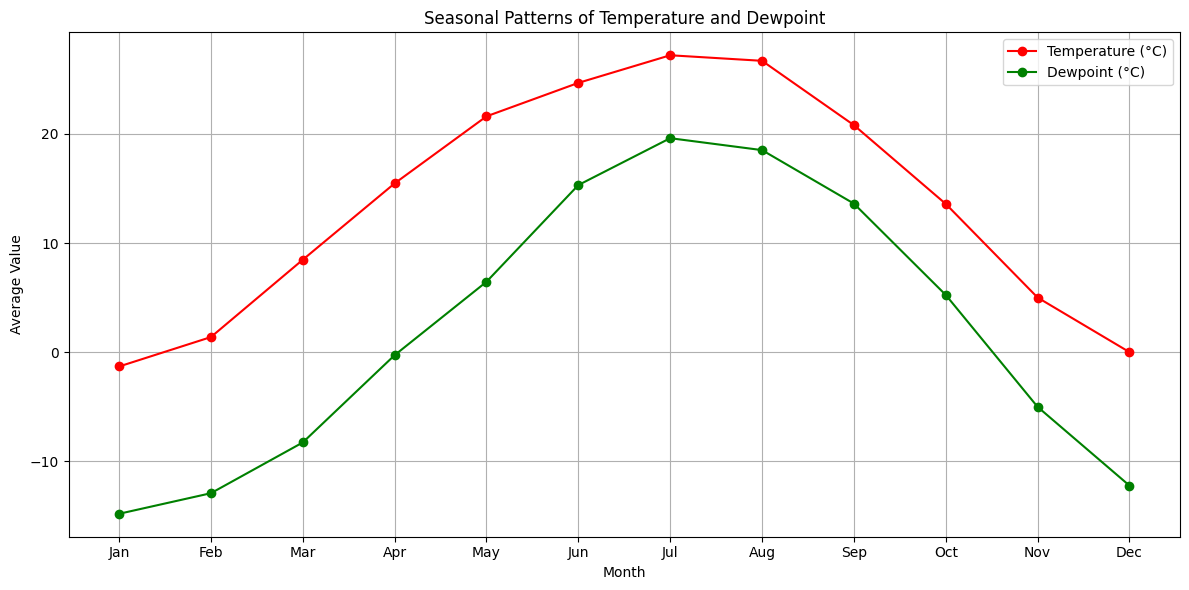

In [ ]:
monthly_seasonal = df.groupby('month')[['TEMP', 'DEWP']].mean().reset_index()

plt.figure(figsize=(12, 6))

plt.plot(monthly_seasonal['month'], monthly_seasonal['TEMP'], marker='o', label='Temperature (°C)', color='red')
plt.plot(monthly_seasonal['month'], monthly_seasonal['DEWP'], marker='o', label='Dewpoint (°C)', color='green')

plt.title('Seasonal Patterns of Temperature and Dewpoint')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The graph presents the seasonal patterns of temperature and dewpoint over the months of a year. Both temperature and dewpoint values increase steadily from January, peaking in July, and then decline toward December. The temperature shows a broader range, reaching around 27°C in summer and dropping below 0°C in winter. Dewpoint values follow a similar trend but remain consistently lower than the temperature, indicating changes in moisture levels. Overall, the chart illustrates a clear seasonal cycle, with warmer and more humid conditions in the summer and cooler, drier air in the winter months.

#### Heatmap of correlations

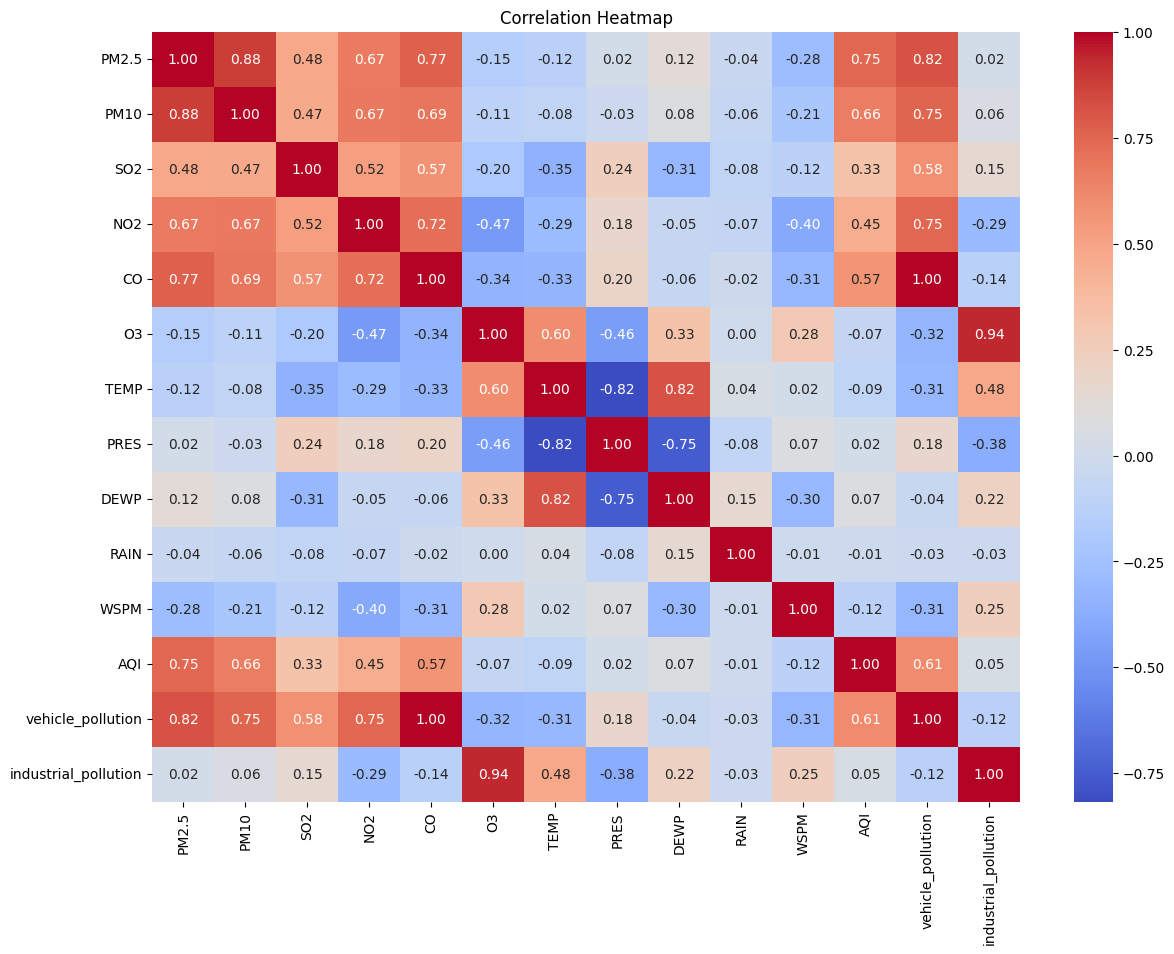

In [ ]:
num_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'AQI', 'vehicle_pollution', 'industrial_pollution']

plt.figure(figsize=(14,10))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

The correlation heatmap illustrates relationships between various environmental variables, including pollutants, weather metrics, and pollution sources. Strong positive correlations can be seen among pollutants like PM2.5, PM10, CO, and NO2, suggesting they often increase together. Vehicle pollution shows a strong positive correlation with PM2.5 (0.82), PM10 (0.75), and CO (0.75), indicating its significant contribution to air pollution. Industrial pollution, on the other hand, is most strongly correlated with O3 (0.94), highlighting a different pollutant profile. Negative correlations between temperature and many pollutants suggest cleaner air during warmer periods, while wind speed and pressure show weak or mixed associations with pollution levels.

## Task 03: Model Building

#### Adding Lag Features:

Lag features are crucial for time series data because they capture the temporal dependencies between past and future values. For example, today's air quality may be influenced by previous days' measurements, and lag features allow the model to learn this relationship. By including lagged values, the model gains additional context, improving its ability to predict future trends and fluctuations. These features help the model detect patterns like seasonality and trends, which are essential for accurate forecasting. Overall, using lag features enhances the model’s performance by providing it with more relevant information about the historical behavior of the data.

In [ ]:
df = df.sort_values(['station', 'year', 'month'])
df['PM2.5_lag1'] = df.groupby('station')['PM2.5'].shift(1)
df['AQI_lag1'] = df.groupby('station')['AQI'].shift(1)
df.dropna(inplace=True)

df.head()

,year,month,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,...,RAIN,wd,WSPM,station,AQI,AQI_category,vehicle_pollution,industrial_pollution,PM2.5_lag1,AQI_lag1
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-03-01 01:00:00,2013.0,3.0,3.0,5.0,6.0,6.0,300.0,85.0,-2.5,1021.3,...,0.0,ENE,0.7,Changping,27.0,Good,314.0,91.0,3.0,27.0
2013-03-01 02:00:00,2013.0,3.0,3.0,5.0,22.0,13.0,400.0,74.0,-3.0,1021.3,...,0.0,ENE,0.2,Changping,23.0,Good,421.0,96.0,3.0,27.0
2013-03-01 03:00:00,2013.0,3.0,3.0,6.0,12.0,8.0,300.0,81.0,-3.6,1021.8,...,0.0,NNE,1.0,Changping,25.0,Good,317.0,93.0,3.0,23.0
2013-03-01 04:00:00,2013.0,3.0,3.0,5.0,14.0,8.0,300.0,81.0,-3.5,1022.3,...,0.0,N,2.1,Changping,25.0,Good,316.0,95.0,3.0,25.0
2013-03-01 05:00:00,2013.0,3.0,3.0,5.0,10.0,17.0,400.0,71.0,-4.5,1022.6,...,0.0,NNW,1.7,Changping,22.0,Good,425.0,81.0,3.0,25.0


#### Split the Dataset:

I split the dataset by `station` and then chronologically within each station to ensure that the model is trained on past data and tested on future data, which aligns with the principles of time series forecasting. By sorting each station’s data by timestamp and then splitting 80% of the data for training, I maintain the chronological order within each station, preventing future data from influencing the training process. This approach ensures that the model is evaluated in a realistic scenario, where it can only learn from past data and is tested on data it has not seen before. This method helps avoid data leakage and guarantees that the model’s predictions are based on temporal patterns that are inherent in the data. Finally, this split allows the model to learn station-specific trends, improving its ability to generalize across different locations.

In [ ]:
# Split data by station, then chronologically within each station
train_data_list = []
test_data_list = []

# Loop through each station in the dataset
for station in df['station'].unique():
    station_data = df[df['station'] == station]

    # Ensure the data is sorted by time (timestamp)
    station_data = station_data.sort_index()

    # Determine split index
    split_index = int(len(station_data) * 0.8)

    # Split data for this station using iloc
    train_data_list.append(station_data.iloc[:split_index])
    test_data_list.append(station_data.iloc[split_index:])

# Combine all the station-specific train and test data
train_data = pd.concat(train_data_list)
test_data = pd.concat(test_data_list)

# Now, you have train_data and test_data with the correct split
X_train = train_data.drop('AQI', axis=1)
y_train = train_data['AQI']
X_test = test_data.drop('AQI', axis=1)
y_test = test_data['AQI']

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")

print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (140250, 20)
y_train Shape: (140250,)
X_test Shape: (35065, 20)
y_test Shape: (35065,)


#### Feature Encoding

Encode categorical variables like `wd`, `station`, `AQI_category`
I used `LabelEncoder` to convert categorical variables into numerical form so that machine learning models can process them effectively. Label encoding assigns a unique integer to each category, making it a simple and efficient transformation. This step ensures that categorical data like `wd`, `station`, and `AQI_category` are appropriately represented in the model.

In [ ]:
categorical_cols = ['wd', 'station', 'AQI_category']

for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [ ]:
print(f"wd in X_train: {X_train['wd'].unique()}")
print(f"Station in X_train: {X_train['station'].unique()}")
print(f"AQI_category in X_train: {X_train['AQI_category'].unique()}")

wd in X_train: [ 1  5  3  6  7  4  0 12 11 15  2  9  8 14 10 13]
Station in X_train: [0 1 2 3 4]
AQI_category in X_train: [0 2 4 3 5 1]


#### Feature Scaling

I used `StandardScaler` to perform feature scaling so that all numerical features have a mean of 0 and a standard deviation of 1. This helps ensure that features with larger ranges (like `CO` or `PM10`) don't dominate those with smaller ranges (like `RAIN` or `TEMP`) in the model training process. Scaling improves the performance of algorithms that are sensitive to the magnitude of input values, especially ensemble methods.

In [ ]:
scaler = StandardScaler()
scaled_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

X_train[scaled_cols] = scaler.fit_transform(X_train[scaled_cols])
X_test[scaled_cols] = scaler.transform(X_test[scaled_cols])

In [ ]:
print("Mean After Scaling in Features:")
X_train[scaled_cols].mean()

Mean After Scaling in Features:


,0
year,2.592952e-14
month,-3.728766e-17
PM2.5,-1.950509e-16
PM10,2.360876e-16
SO2,4.255657e-17
NO2,-2.148094e-17
CO,-2.423698e-16
O3,1.215902e-17
TEMP,-1.694157e-16
PRES,9.478361e-15


In [ ]:
print("Std After Scaling in Features:")
X_train[scaled_cols].std()

Std After Scaling in Features:


,0
year,1.000004
month,1.000004
PM2.5,1.000004
PM10,1.000004
SO2,1.000004
NO2,1.000004
CO,1.000004
O3,1.000004
TEMP,1.000004
PRES,1.000004


#### Feature Selection:

Feature importance helps me identify the most relevant features in my dataset, allowing me to focus on those that have the greatest impact on the model's predictions. By using a model like `Random Forest`, which naturally computes feature importance, I can rank the features based on how much they contribute to the target variable. Selecting the top features reduces dimensionality, making my model more efficient and easier to interpret. It also helps prevent overfitting by eliminating irrelevant or redundant features, improving the model's ability to generalize. Overall, feature selection through importance leads to better performance and faster training times.

In [ ]:
# Fit a RandomForestRegressor model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Get feature importance
feature_importances = model.feature_importances_

# Create a DataFrame with features and their importance scores
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the top features
print(importance_df)

                 Feature  Importance
19              AQI_lag1    0.946757
15          AQI_category    0.049454
2                  PM2.5    0.001392
7                     O3    0.000876
18            PM2.5_lag1    0.000261
3                   PM10    0.000218
5                    NO2    0.000169
9                   PRES    0.000116
10                  DEWP    0.000104
17  industrial_pollution    0.000100
8                   TEMP    0.000099
16     vehicle_pollution    0.000084
13                  WSPM    0.000084
4                    SO2    0.000064
12                    wd    0.000063
1                  month    0.000052
14               station    0.000035
6                     CO    0.000035
0                   year    0.000029
11                  RAIN    0.000007


The feature selection output indicates that the most important feature for predicting AQI is `AQI_lag1`, with a high importance score, reflecting the significant influence of past AQI values on future predictions. Other important features include `AQI_category`, `PM2.5`, `O3`, and `PM2.5_lag1`, which suggest that air quality categories and pollutant levels play a role in predicting AQI. Features like `PM10`, `NO2`, `PRES`, and `DEWP` also contribute but to a lesser extent. Less important features such as `month`, `year`, and `wd` were deemed less relevant for predicting AQI. Based on this, the top 10 features were selected to enhance the model's predictive power while reducing noise.

In [ ]:
# Select top 10 important features
top_features = importance_df['Feature'].head(10).tolist()

# Filter the train and test sets to use only the top 10 selected features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

print(f"X_train_selected shape: {X_train_selected.shape}")
print(f"X_test_selected shape: {X_test_selected.shape}")

X_train_selected shape: (140250, 10)
X_test_selected shape: (35065, 10)


#### Model 01: RandomForestRegressor

In [ ]:
# Random Forest Regressor
rf_model = RandomForestRegressor()

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, scoring='neg_mean_absolute_error')
rf_grid_search.fit(X_train_selected, y_train)

# Best Random Forest Model
print("Best Random Forest Parameters:", rf_grid_search.best_params_)
rf_best_model = rf_grid_search.best_estimator_

Best Random Forest Parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300, 'random_state': 42}


###### Save RandomForestRegressor Model

In [ ]:
joblib.dump(rf_best_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

###### Load RandomForestRegressor Model

In [ ]:
# Load Random Forest model
rf_model = joblib.load('random_forest_model.pkl')

###### RandomForestRegressor Model Evaluation

In [ ]:
rf_pred = rf_model.predict(X_test_selected)

rf_mae = mean_absolute_error(y_test, rf_pred)
print(f"RandomForestRegressor model MAE: {np.round(rf_mae,4)}")

rf_mse = mean_squared_error(y_test, rf_pred)
print(f"RandomForestRegressor model MSE: {np.round(rf_mse,4)}")

rf_rmse = np.sqrt(rf_mse)
print(f"RandomForestRegressor model RMSE: {np.round(rf_rmse,4)}")

rf_r2 = r2_score(y_test, rf_pred)
print(f"RandomForestRegressor model R-Squared Error: {np.round(rf_r2,4)}")

RandomForestRegressor model MAE: 1.6919
RandomForestRegressor model MSE: 6.9353
RandomForestRegressor model RMSE: 2.6335
RandomForestRegressor model R-Squared Error: 0.9988


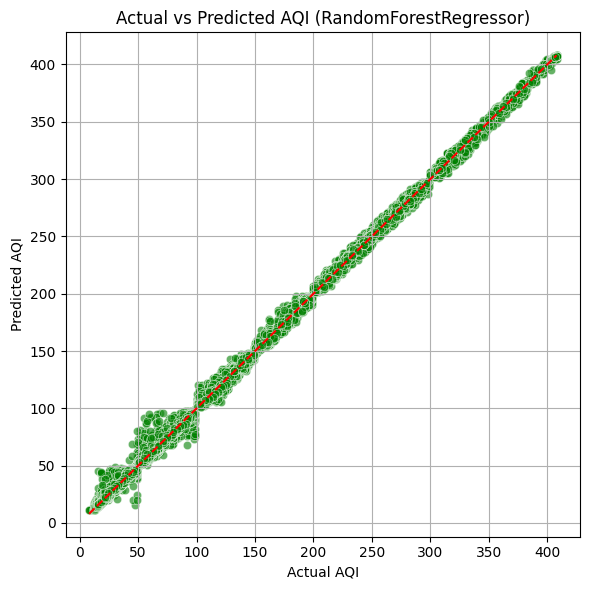

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=rf_pred, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI (RandomForestRegressor)')
plt.grid(True)
plt.tight_layout()
plt.show()

The scatter plot shows the actual versus predicted AQI (Air Quality Index) values from the **RandomForestRegressor** model. Each green dot represents a prediction, and the red diagonal line indicates perfect predictions where actual equals predicted. The points closely follow the red line, showing that the model's predictions are highly accurate across the entire range of AQI values. There is very little deviation from the line, especially for higher AQI values, indicating a low error rate and strong model generalization. This visualization confirms the model's excellent performance and aligns well with the high R2 score and low error metrics observed.

###### RandomForestRegressor: Train vs. Test Performance Evaluation

In [ ]:
# Predictions on training set
rf_train_pred = rf_model.predict(X_train_selected)

# Training metrics
rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_train_mse = mean_squared_error(y_train, rf_train_pred)
rf_train_rmse = np.sqrt(rf_train_mse)
rf_train_r2 = r2_score(y_train, rf_train_pred)

# Display in a table
rf_model_metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R2'],
    'Train': [rf_train_mae, rf_train_mse, rf_train_rmse, rf_train_r2],
    'Test': [rf_mae, rf_mse, rf_rmse, rf_r2]
})

rf_model_metrics_df

,Metric,Train,Test
0,MAE,1.276527,1.691896
1,MSE,3.902378,6.935275
2,RMSE,1.975444,2.633491
3,R2,0.999275,0.998760


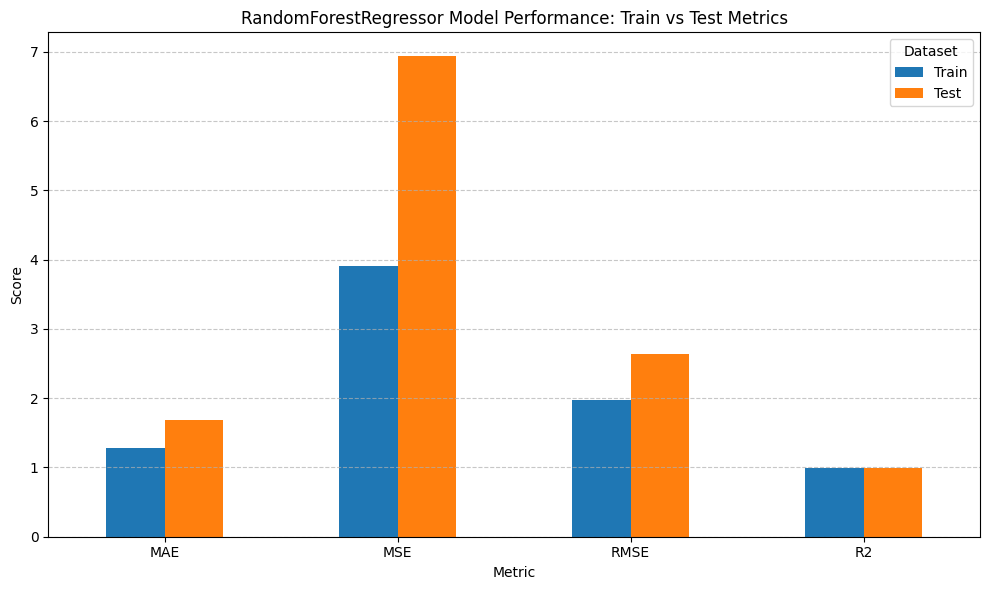

In [ ]:
# Set 'Metric' column as index
rf_model_metrics_df_plot = rf_model_metrics_df.set_index('Metric')

# Plot
rf_model_metrics_df_plot.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('RandomForestRegressor Model Performance: Train vs Test Metrics')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

This bar chart compares the **training and testing performance** of the **Random Forest model** using four evaluation metrics: **MAE, MSE, RMSE, and R2**. The **Mean Absolute Error (MAE)** is slightly higher on the test set (1.69) than the train set (1.28), indicating a small difference in prediction accuracy. Similarly, the **Mean Squared Error (MSE)** and **Root Mean Squared Error (RMSE)** are also slightly higher in the test set, suggesting minimal loss of accuracy when generalizing to new data. The **R2 score**, which measures how well the model explains the variance in the data, is extremely high for both training (0.9993) and testing (0.9988), showing that the model captures the patterns in the data very well. Overall, the small performance gap and high R2 values suggest that the model is **not overfitting** and generalizes effectively.

#### Model 02: AdaBoostRegressor

In [ ]:
ada_model = AdaBoostRegressor()

ada_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
    'random_state': [42]
}

ada_grid_search = GridSearchCV(estimator=ada_model, param_grid=ada_param_grid, cv=5, scoring='neg_mean_absolute_error')
ada_grid_search.fit(X_train_selected, y_train)

# Best AdaBoost Model
print("Best AdaBoost Parameters:", ada_grid_search.best_params_)
ada_best_model = ada_grid_search.best_estimator_

Best AdaBoost Parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42}


###### Save AdaBoostRegressor Model

In [ ]:
joblib.dump(ada_best_model, 'ada_boost_model.pkl')

['ada_boost_model.pkl']

###### Load AdaBoostRegressor Model

In [ ]:
ada_model = joblib.load('ada_boost_model.pkl')

###### AdaBoostRegressor Model Evaluation

In [ ]:
ada_pred = ada_model.predict(X_test_selected)

ada_mae = mean_absolute_error(y_test, ada_pred)
print(f"AdaBoostRegressor model MAE: {np.round(ada_mae,4)}")

ada_mse = mean_squared_error(y_test, ada_pred)
print(f"AdaBoostRegressor model MSE: {np.round(ada_mse,4)}")

ada_rmse = np.sqrt(ada_mse)
print(f"AdaBoostRegressor model RMSE: {np.round(ada_rmse,4)}")

ada_r2 = r2_score(y_test, ada_pred)
print(f"AdaBoostRegressor model R-Squared Error: {np.round(ada_r2,4)}")

AdaBoostRegressor model MAE: 7.4533
AdaBoostRegressor model MSE: 83.6531
AdaBoostRegressor model RMSE: 9.1462
AdaBoostRegressor model R-Squared Error: 0.985


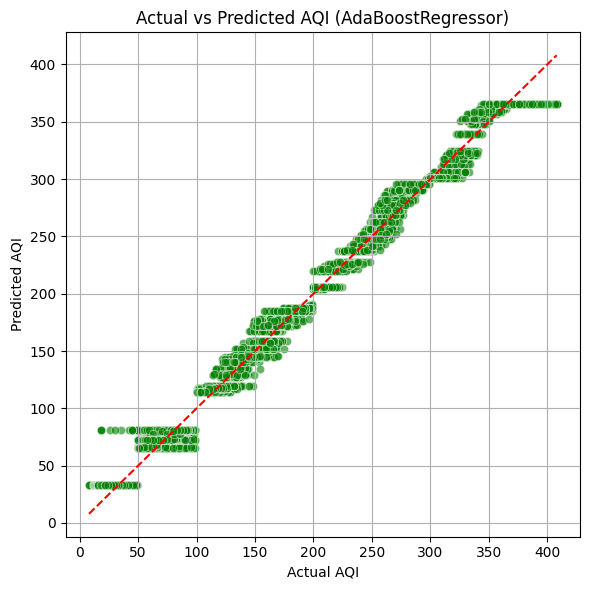

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=ada_pred, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI (AdaBoostRegressor)')
plt.grid(True)
plt.tight_layout()
plt.show()

This scatter plot shows the **Actual vs. Predicted AQI values** using the **AdaBoost Regressor model**. Ideally, predictions should lie along the red dashed diagonal line, which represents perfect predictions. In this plot, although many points follow the general trend of the line, there are noticeable deviations, especially at the **lower and upper ends** of the AQI scale. This indicates that the model **underperforms** in accurately predicting very low or very high AQI values. The clustering of points into horizontal bands suggests **limited prediction granularity**, possibly due to weaker learners in the ensemble. Overall, while the model captures the trend, it lacks the precision and flexibility shown by other models like Random Forest or XGBoost.

###### AdaBoostRegressor: Train vs. Test Performance Evaluation

In [ ]:
# Predictions on training set
ada_train_pred = ada_model.predict(X_train_selected)

# Training metrics
ada_train_mae = mean_absolute_error(y_train, ada_train_pred)
ada_train_mse = mean_squared_error(y_train, ada_train_pred)
ada_train_rmse = np.sqrt(ada_train_mse)
ada_train_r2 = r2_score(y_train, ada_train_pred)

# Display in a table
ada_model_metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R2'],
    'Train': [ada_train_mae, ada_train_mse, ada_train_rmse, ada_train_r2],
    'Test': [ada_mae, ada_mse, ada_rmse, ada_r2]
})

ada_model_metrics_df

,Metric,Train,Test
0,MAE,7.202828,7.453295
1,MSE,75.422369,83.653135
2,RMSE,8.684605,9.146209
3,R2,0.985996,0.985045


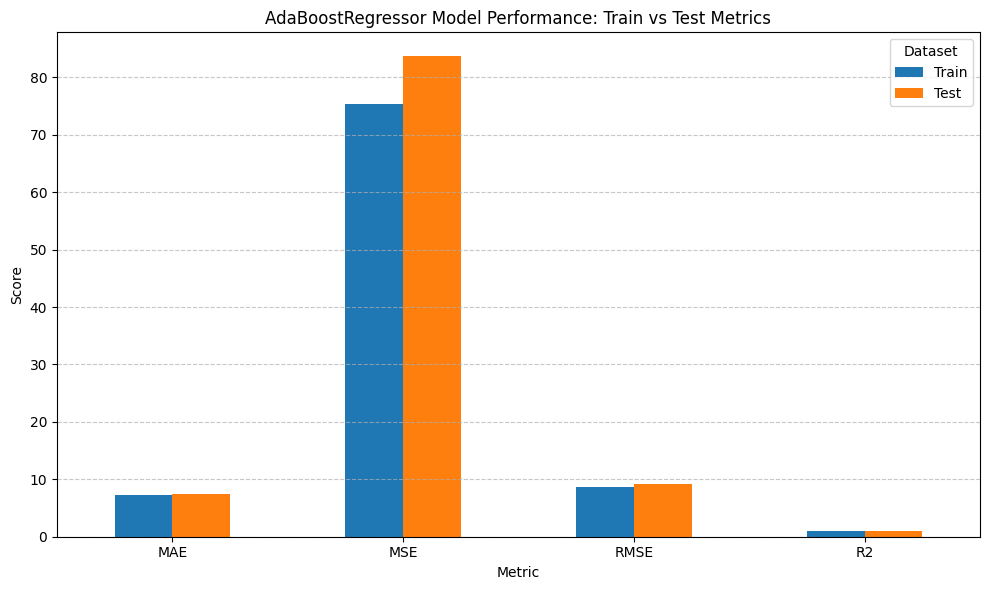

In [ ]:
# Set 'Metric' column as index
ada_model_metrics_df_plot = ada_model_metrics_df.set_index('Metric')

# Plot
ada_model_metrics_df_plot.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('AdaBoostRegressor Model Performance: Train vs Test Metrics')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

This bar chart shows the performance of the **AdaBoost Regressor** on both the training and test datasets using four evaluation metrics: MAE, MSE, RMSE, and R2. The **Mean Absolute Error (MAE)** is about **7.20 on training** and **7.45 on testing**, indicating the model makes an average error of around 7 units in AQI prediction. The **Mean Squared Error (MSE)** and **Root Mean Squared Error (RMSE)** are also relatively high, especially on the test set (RMSE ≈ 9.15), suggesting some large prediction errors. The **R2 score** is around **0.986** on both sets, showing the model explains about **98.6%** of the variance in AQI, which is strong but slightly weaker than Random Forest or XGBoost. The small performance gap between training and test sets suggests **low overfitting**, but overall accuracy is **moderate** compared to other models.

#### Model 03: XGBRegressor

In [ ]:
# XGBoost Regressor
xgb_model = xgb.XGBRegressor()

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'random_state': [42]
}

xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, scoring='neg_mean_absolute_error')
xgb_grid_search.fit(X_train_selected, y_train)

# Best XGBoost Model
print("Best XGBoost Parameters:", xgb_grid_search.best_params_)
xgb_best_model = xgb_grid_search.best_estimator_

Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'random_state': 42, 'subsample': 0.8}


###### Save XGBRegressor Model

In [ ]:
joblib.dump(xgb_best_model, 'xgb_model.pkl')

['xgb_model.pkl']

###### Load XGBRegressor Model

In [ ]:
xgb_model = joblib.load('xgb_model.pkl')

###### XGBRegressor Model Evaluation

In [ ]:
xgb_pred = xgb_model.predict(X_test_selected)

xgb_mae = mean_absolute_error(y_test, xgb_pred)
print(f"XGBRegressor model MAE: {np.round(xgb_mae,4)}")

xgb_mse = mean_squared_error(y_test, xgb_pred)
print(f"XGBRegressor model MSE: {np.round(xgb_mse,4)}")

xgb_rmse = np.sqrt(xgb_mse)
print(f"XGBRegressor model RMSE: {np.round(xgb_rmse,4)}")

xgb_r2 = r2_score(y_test, xgb_pred)
print(f"XGBRegressor model R-Squared Error: {np.round(xgb_r2,4)}")

XGBRegressor model MAE: 1.7985
XGBRegressor model MSE: 7.7417
XGBRegressor model RMSE: 2.7824
XGBRegressor model R-Squared Error: 0.9986


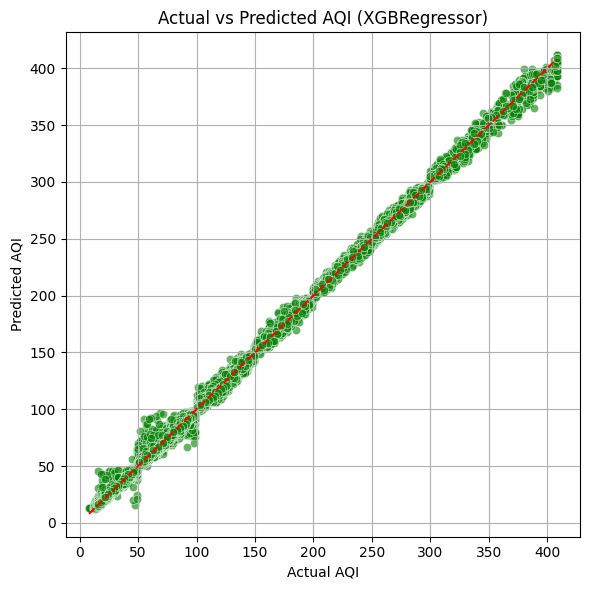

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=xgb_pred, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI (XGBRegressor)')
plt.grid(True)
plt.tight_layout()
plt.show()

This scatter plot shows the **actual vs. predicted AQI values** for the **XGBRegressor** model. The green dots represent predictions, and the red dashed line indicates a perfect match where predicted AQI equals actual AQI. The points lie very close to the red line, forming a tight cluster along it, which indicates **high prediction accuracy** and **strong correlation** between actual and predicted values. The consistent alignment suggests the model captures the underlying patterns in the data very well, with minimal error. This visualization confirms that **XGBRegressor performs exceptionally well** for AQI prediction.

###### XGBRegressor: Train vs. Test Performance Evaluation

In [ ]:
# Predictions on training set
xgb_train_pred = xgb_model.predict(X_train_selected)

# Training metrics
xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
xgb_train_mse = mean_squared_error(y_train, xgb_train_pred)
xgb_train_rmse = np.sqrt(xgb_train_mse)
xgb_train_r2 = r2_score(y_train, xgb_train_pred)

# Display in a table
xgb_model_metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R2'],
    'Train': [xgb_train_mae, xgb_train_mse, xgb_train_rmse, xgb_train_r2],
    'Test': [xgb_mae, xgb_mse, xgb_rmse, xgb_r2]
})

xgb_model_metrics_df

,Metric,Train,Test
0,MAE,1.402543,1.798518
1,MSE,4.398481,7.741702
2,RMSE,2.097256,2.782391
3,R2,0.999183,0.998616


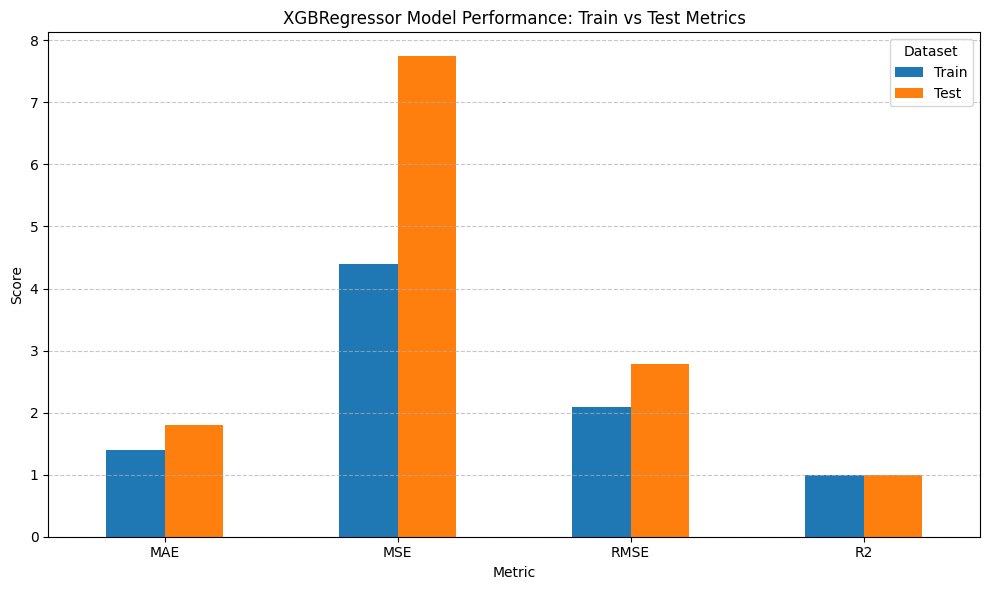

In [ ]:
# Set 'Metric' column as index
xgb_model_metrics_df_plot = xgb_model_metrics_df.set_index('Metric')

# Plot
xgb_model_metrics_df_plot.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('XGBRegressor Model Performance: Train vs Test Metrics')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

The bar graph presents the performance metrics for an XGBoost model, comparing the results on both the training and test datasets. The MAE (Mean Absolute Error) is lower on the training set (1.40) than on the test set (1.80), indicating that the model performs slightly better on training data. The MSE (Mean Squared Error) and RMSE (Root Mean Squared Error) also show a similar trend, with higher values on the test set (7.74 and 2.78, respectively) compared to the training set (4.40 and 2.10), suggesting some overfitting to the training data. The R2 score, which measures the model’s goodness of fit, is very high for both sets, but slightly lower on the test set (0.9986) than on the training set (0.9992), implying that the model generalizes well but with a minor reduction in predictive power on unseen data. Overall, the model shows strong performance but may benefit from some regularization to reduce overfitting.

#### Models Performance Evaluation

In [ ]:
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'AdaBoost', 'XGBoost'],
    'MAE': [rf_mae, ada_mae, xgb_mae],
    'MSE': [rf_mse, ada_mse, xgb_mse],
    'RMSE': [rf_rmse, ada_rmse, xgb_rmse],
    'R-Squared': [rf_r2, ada_r2, xgb_r2]
})

metrics_df

,Model,MAE,MSE,RMSE,R-Squared
0,Random Forest,1.691896,6.935275,2.633491,0.998760
1,AdaBoost,7.453295,83.653135,9.146209,0.985045
2,XGBoost,1.798518,7.741702,2.782391,0.998616


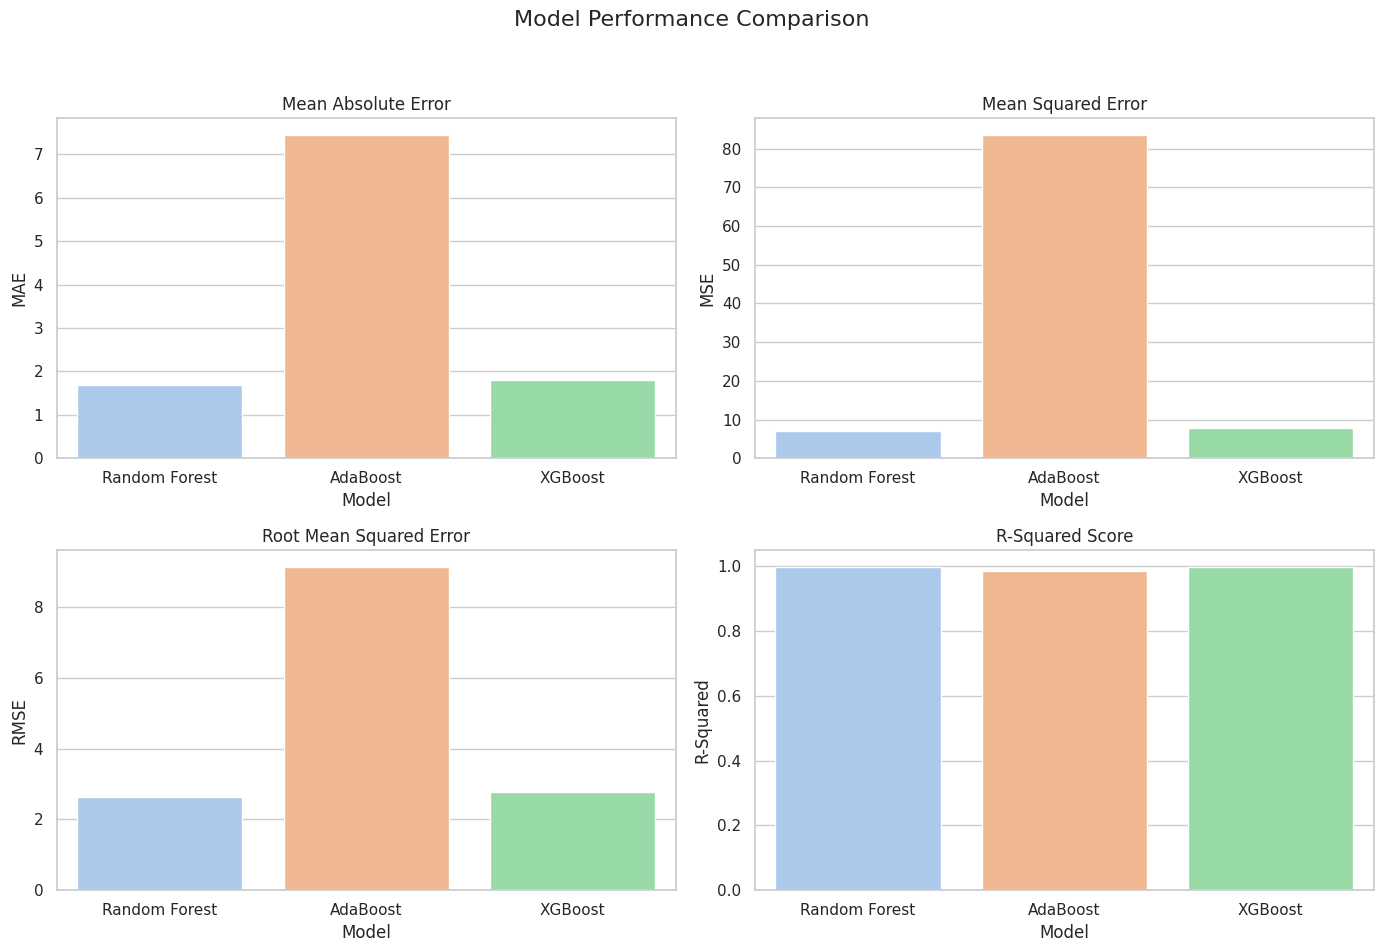

In [ ]:
# Set plot style
sns.set(style='whitegrid')
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# MAE Plot
sns.barplot(x='Model', y='MAE', data=metrics_df, ax=axs[0, 0], palette='pastel')
axs[0, 0].set_title('Mean Absolute Error')

# MSE Plot
sns.barplot(x='Model', y='MSE', data=metrics_df, ax=axs[0, 1], palette='pastel')
axs[0, 1].set_title('Mean Squared Error')

# RMSE Plot
sns.barplot(x='Model', y='RMSE', data=metrics_df, ax=axs[1, 0], palette='pastel')
axs[1, 0].set_title('Root Mean Squared Error')

# R2 Plot
sns.barplot(x='Model', y='R-Squared', data=metrics_df, ax=axs[1, 1], palette='pastel')
axs[1, 1].set_title('R-Squared Score')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

`Random Forest` and `XGBoost` show very similar results with low error metrics (MAE, MSE, RMSE) and very high R-squared values (~0.999), indicating excellent prediction performance.

`AdaBoost` performs significantly worse, with higher errors and a lower R-squared score, suggesting it struggles more with capturing the underlying patterns in the data.

Overall, `Random Forest` slightly outperforms `XGBoost` in most metrics, making it the best model in this case based on evaluation results. ​

## Task 04: Application development

#### Install Streamlit

In [7]:
!pip install streamlit

#### Mount Google Drive and Load the Datasets

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd '/content/drive/MyDrive/datasets/assessment_datasets'

/content/drive/MyDrive/datasets/assessment_datasets


In [ ]:
%ls

ada_boost_model.pkl
air_quality_data_combined.csv
app.py
combined_output.csv
graphs_plot_helper.py
home.py
modeling.py
plots.py
processed_data.py
PRSA_Data_Aotizhongxin_20130301-20170228.csv
PRSA_Data_Changping_20130301-20170228.csv
PRSA_Data_Dingling_20130301-20170228.csv
PRSA_Data_Dongsi_20130301-20170228.csv
PRSA_Data_Guanyuan_20130301-20170228.csv
PRSA_Data_Gucheng_20130301-20170228.csv
PRSA_Data_Huairou_20130301-20170228.csv
PRSA_Data_Nongzhanguan_20130301-20170228.csv
PRSA_Data_Shunyi_20130301-20170228.csv
PRSA_Data_Tiantan_20130301-20170228.csv
PRSA_Data_Wanliu_20130301-20170228.csv
PRSA_Data_Wanshouxigong_20130301-20170228.csv
__pycache__/
random_forest_model.pkl
summary.py
utils.py
visualization.py
xgb_model.pkl


#### Helper Functions

In [68]:
%%writefile utils.py

import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# load the csv file
@st.cache_data
def load_data_from_drive():
    df = pd.read_csv("air_quality_data_combined.csv")
    return df

@st.cache_data
def load_models():
    models = {}
    try:
        models['RandomForest'] = joblib.load('random_forest_model.pkl')
        models['AdaBoost'] = joblib.load('ada_boost_model.pkl')
        models['XGBoost'] = joblib.load('xgb_model.pkl')
    except Exception as e:
        print(f"Error loading models: {e}")

    return models

@st.cache_data
def handling_missing_values(df):
  # Impute numerical columns with the mean
  numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

  # Create an imputer for numerical data
  numerical_imputer = SimpleImputer(strategy='mean')

  # Apply the imputer to the numerical columns
  df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

  # Impute categorical columns with the mode (most frequent value)
  categorical_cols = df.select_dtypes(include=['object']).columns

  # Create an imputer for categorical data
  categorical_imputer = SimpleImputer(strategy='most_frequent')

  # Apply the imputer to the categorical columns
  df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

  return df

@st.cache_data
def outlier_handling(df):
  # Select only numerical columns
  numeric_cols = df.select_dtypes(include=['number']).columns.to_list()
  numeric_cols.remove('No') # excluding `No` column
  numeric_cols.remove('year') # excluding `year` column
  numeric_cols.remove('month') # excluding `month` column
  numeric_cols.remove('day') # excluding `day` column
  numeric_cols.remove('hour') # excluding `hour` column

  # Winsorization (1st and 99th percentiles)
  for col in numeric_cols:
      lower = df[col].quantile(0.01)
      upper = df[col].quantile(0.99)
      df[col] = df[col].clip(lower=lower, upper=upper)

  return df

@st.cache_data
def create_timestamp_col(df):
    # Create `timestamp` column
  df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

  # Set `timestamp` as the index
  df = df.set_index('timestamp')

  # Drop `No`, `day`, `hour`
  df = df.drop(['No', 'day', 'hour'], axis=1)

  return df


@st.cache_data
def calculate_aqi(conc, breakpoints):
    for C_low, C_high, I_low, I_high in breakpoints:
        if C_low <= conc <= C_high:
            return ((I_high - I_low) / (C_high - C_low)) * (conc - C_low) + I_low
    return np.nan

@st.cache_data
def create_aqi_column(df):
  # breakpoint for calculating AQI for each one
  breakpoints_pm25_per_day = [(0, 35, 0, 50), (35, 75, 51, 100), (75, 115, 101, 150), (115, 150, 151, 200),
                      (150, 250, 201, 300), (250, 350, 301, 400), (350, 500, 401, 500)]

  breakpoints_pm10_per_day = [(0, 50, 0, 50), (51, 150, 51, 100), (151, 250, 101, 150), (251, 350, 151, 200),
                      (350, 420, 201, 300), (420, 500, 301, 400), (500, 600, 401, 500)]

  breakpoints_so2_per_hour = [(0, 150, 0, 50), (151, 500, 51, 100), (501, 650, 101, 150), (651, 800, 151, 200),
                     (801, 1600, 201, 300), (1601, 2100, 301, 400), (2100, 2620, 401, 500)]

  breakpoints_no2_per_hour = [(0, 100, 0, 50), (101, 200, 51, 100), (201, 700, 101, 150), (701, 1200, 151, 200),
                     (1201, 2340, 201, 300), (2341, 3090, 301, 400), (3091, 3840, 401, 500)]

  breakpoints_co_per_hour = [(0, 5000, 0, 50), (5001, 10000, 51, 100), (10001, 35000, 101, 150), (35001, 60000, 151, 200),
                    (60001, 90000, 201, 300), (90001, 120000, 301, 400), (120001, 150000, 401, 500)]

  breakpoints_o3_per_hour = [(0, 160, 0, 50), (161, 200, 51, 100), (201, 300, 101, 150), (301, 400, 151, 200),
                    (401, 800, 201, 300), (801, 1000, 301, 400), (1001, 1200, 401, 500)]

  # 24-hour averages for PM2.5 and PM10
  df['PM2.5_24h'] = df['PM2.5'].rolling(window=24, min_periods=1).mean()
  df['PM10_24h'] = df['PM10'].rolling(window=24, min_periods=1).mean()

  # AQI per pollutant
  df['AQI_PM25'] = df['PM2.5_24h'].apply(lambda x: calculate_aqi(x, breakpoints_pm25_per_day))
  df['AQI_PM10'] = df['PM10_24h'].apply(lambda x: calculate_aqi(x, breakpoints_pm10_per_day))
  df['AQI_SO2'] = df['SO2'].apply(lambda x: calculate_aqi(x, breakpoints_so2_per_hour))
  df['AQI_NO2'] = df['NO2'].apply(lambda x: calculate_aqi(x, breakpoints_no2_per_hour))
  df['AQI_CO'] = df['CO'].apply(lambda x: calculate_aqi(x, breakpoints_co_per_hour))
  df['AQI_O3'] = df['O3'].apply(lambda x: calculate_aqi(x, breakpoints_o3_per_hour))

  # Final AQI: max value among all pollutants
  df['AQI'] = df[['AQI_PM25', 'AQI_PM10', 'AQI_SO2', 'AQI_NO2', 'AQI_CO', 'AQI_O3']].max(axis=1).round()

  # Keeping only `AQI` column, droping other column related to calculating AQI
  df.drop(['PM2.5_24h', 'PM10_24h', 'AQI_PM25', 'AQI_PM10', 'AQI_SO2', 'AQI_NO2', 'AQI_CO', 'AQI_O3'], axis=1, inplace=True)

  return df


@st.cache_data
def create_aqi_category_column(df):
  bins = [0, 50, 100, 150, 200, 300, float('inf')]
  labels = ['Good', 'Moderate', 'Unhealthy for sensitive group', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

  df['AQI_category'] = pd.cut(df['AQI'], bins=bins, labels=labels, right=False)

  return df

@st.cache_data
def execute_feature_extraction_operations(df):
  df = create_timestamp_col(df)
  #adding two new columns
  df['vehicle_pollution'] = df[['PM2.5', 'PM10', 'NO2', 'CO']].sum(axis=1)
  df['industrial_pollution'] = df[['SO2', 'O3']].sum(axis=1)
  df = create_aqi_column(df)
  df = create_aqi_category_column(df)

  return df

@st.cache_data
def adding_lag_feature(df):
  df = df.sort_values(['station', 'year', 'month'])
  df['PM2.5_lag1'] = df.groupby('station')['PM2.5'].shift(1)
  df['AQI_lag1'] = df.groupby('station')['AQI'].shift(1)
  df.dropna(inplace=True)

  return df

@st.cache_data
def splitting_data_set(df):
  # Split data by station, then chronologically within each station
  train_data_list = []
  test_data_list = []

  # Loop through each station in the dataset
  for station in df['station'].unique():
      station_data = df[df['station'] == station]

      # Ensure the data is sorted by time (timestamp)
      station_data = station_data.sort_index()

      # Determine split index
      split_index = int(len(station_data) * 0.8)

      # Split data for this station using iloc
      train_data_list.append(station_data.iloc[:split_index])
      test_data_list.append(station_data.iloc[split_index:])

  # Combine all the station-specific train and test data
  train_data = pd.concat(train_data_list)
  test_data = pd.concat(test_data_list)

  # Now, you have train_data and test_data with the correct split
  X_train = train_data.drop('AQI', axis=1)
  y_train = train_data['AQI']
  X_test = test_data.drop('AQI', axis=1)
  y_test = test_data['AQI']

  return X_train, y_train, X_test, y_test

@st.cache_data
def feature_encoding(X_train, X_test):
  categorical_cols = ['wd', 'station', 'AQI_category']

  for col in categorical_cols:
      le = LabelEncoder()
      X_train[col] = le.fit_transform(X_train[col])
      X_test[col] = le.transform(X_test[col])

  return X_train, X_test

@st.cache_data
def feature_scaling(X_train, X_test):
  scaler = StandardScaler()
  scaled_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

  X_train[scaled_cols] = scaler.fit_transform(X_train[scaled_cols])
  X_test[scaled_cols] = scaler.transform(X_test[scaled_cols])

  return X_train, X_test

@st.cache_data
def execute_data_preprocessing(df):
  df = adding_lag_feature(df)

  X_train, y_train, X_test, y_test = splitting_data_set(df)

  X_train, X_test = feature_encoding(X_train, X_test)

  X_train, X_test = feature_scaling(X_train, X_test)

  return X_train, y_train, X_test, y_test

@st.cache_data
def execute_feature_selection(X_train, y_train):
  # Fit a RandomForestRegressor model
  model = RandomForestRegressor()
  model.fit(X_train, y_train)

  # Get feature importance
  feature_importances = model.feature_importances_

  # Create a DataFrame with features and their importance scores
  importance_df = pd.DataFrame({
      'Feature': X_train.columns,
      'Importance': feature_importances
  })

  # Sort features by importance
  importance_df = importance_df.sort_values(by='Importance', ascending=False)

  return importance_df

def show_model_results(models, model_name, X_test, y_test):
    model = models.get(model_name)

    if model:
        # Predict
        y_pred = model.predict(X_test)

        # Metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Display metrics
        metrics_df = pd.DataFrame({
            "Metric": ["MAE", "MSE", "RMSE", "R2 Score"],
            "Value": [mae, mse, rmse, r2]
        })

        st.markdown("#### 📊 Model Performance Metrics")
        st.table(metrics_df)

        # Actual vs Predicted Plot
        st.markdown("#### 📈 Actual vs Predicted AQI")
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.scatterplot(x=y_test, y=y_pred, color='green', alpha=0.6, ax=ax)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
        ax.set_xlabel("Actual AQI")
        ax.set_ylabel("Predicted AQI")
        ax.set_title(f"Actual vs Predicted AQI ({model_name})")
        ax.grid(True)
        plt.tight_layout()
        st.pyplot(fig)


    else:
        st.error(f"❌ {model_name} model not found.")

Overwriting utils.py


#### Plot the Visualizations

In [61]:
%%writefile graphs_plot_helper.py

import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

@st.cache_data
def plot_average_aqi_per_year(df):
  # Group by year and calculate mean AQI
  yearly_avg = df.groupby('year')['AQI'].mean().reset_index()

  fig, ax = plt.subplots(figsize=(10, 5))

  sns.pointplot(x='year', y='AQI', data=yearly_avg, color='blue', markers='o', linestyles='-', ax=ax)
  ax.set_title('Average AQI per Year')
  ax.set_ylabel('Average AQI')
  ax.set_xlabel('Year')
  plt.tight_layout()
  return fig


@st.cache_data
def plot_stationwise_aqi(df):
    yearly_avg_by_station = df.groupby(['year', 'station'])['AQI'].mean().reset_index()

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.pointplot(data=yearly_avg_by_station, x='year', y='AQI', hue='station', palette='husl', linestyles='-', ax=ax)
    ax.set_title('Average AQI per Year per Station (2013–2017)')
    ax.set_ylabel('Average AQI')
    ax.set_xlabel('Year')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()

    return fig

@st.cache_data
def plot_monthlywise_aqi_per_year(df):
  monthly_yearly_avg = df.groupby(['year', 'month'])['AQI'].mean().reset_index()

  fig, ax = plt.subplots(figsize=(10, 5))
  sns.pointplot(data=monthly_yearly_avg, x='month', y='AQI', hue='year', palette='viridis', linestyles='-')
  ax.set_title('Average Monthly AQI per Year (2013–2017)')
  ax.set_ylabel('Average AQI')
  ax.set_xlabel('Month')
  ax.tick_params(axis='x', rotation=45)
  plt.tight_layout()

  return fig

# 2
@st.cache_data
def plot_yearly_pollution_trend(df):
    yearly_avg = df.groupby(['year'])[['vehicle_pollution', 'industrial_pollution']].mean().reset_index()

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(data=yearly_avg, x='year', y='vehicle_pollution', label='Vehicle Pollution', color='blue', marker='o')
    sns.lineplot(data=yearly_avg, x='year', y='industrial_pollution', label='Industrial Pollution', color='orange', marker='o')
    ax.set_title('Yearly Average Pollution Trend')
    ax.set_xlabel('Year')
    ax.set_ylabel('Pollution Level')
    ax.legend()
    plt.tight_layout()

    return fig

@st.cache_data
def plot_monthly_pollution_pattern(df):
    monthly_seasonal = df.groupby('month')[['vehicle_pollution', 'industrial_pollution']].mean().reset_index()

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(data=monthly_seasonal, x='month', y='vehicle_pollution', label='Vehicle Pollution', color='blue', marker='o')
    sns.lineplot(data=monthly_seasonal, x='month', y='industrial_pollution', label='Industrial Pollution', color='orange', marker='o')
    ax.set_title('Seasonal Pollution Pattern (Monthly Average)')
    ax.set_xlabel('Month')
    ax.set_ylabel('Pollution Level')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.legend()
    plt.tight_layout()

    return fig

@st.cache_data
def plot_yearly_pollution_contribution(df):
    yearly_pollution = df.groupby('year')[['vehicle_pollution', 'industrial_pollution']].sum().reset_index()

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(yearly_pollution['year'], yearly_pollution['vehicle_pollution'], label='Vehicle Pollution', color='skyblue')
    ax.bar(yearly_pollution['year'], yearly_pollution['industrial_pollution'],
           bottom=yearly_pollution['vehicle_pollution'], label='Industrial Pollution', color='orange')

    ax.set_title('Vehicle vs Industrial Pollution Contribution by Year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Pollution')
    ax.legend()
    plt.tight_layout()

    return fig

@st.cache_data
def plot_pollution_by_station_and_year(df):
    pollution_by_station_year = df.groupby(['station', 'year'])[['vehicle_pollution', 'industrial_pollution']].sum().reset_index()

    df_melted = pollution_by_station_year.melt(
        id_vars=['station', 'year'],
        value_vars=['vehicle_pollution', 'industrial_pollution'],
        var_name='Pollution_Type',
        value_name='Pollution_Level'
    )

    g = sns.catplot(
        data=df_melted,
        x='year', y='Pollution_Level',
        hue='Pollution_Type',
        col='station',
        kind='bar',
        col_wrap=2,
        height=4,
        aspect=1.2,
        palette='Set2'
    )

    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('Pollution Type Contribution by Station and Year')
    plt.tight_layout()

    return g.fig

# 3
@st.cache_data
def plot_rainfall_vs_aqi(df):
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(data=df, x='RAIN', y='AQI', alpha=0.6, ax=ax)
    sns.regplot(data=df, x='RAIN', y='AQI', scatter=False, color='red', label='Trend Line', ax=ax)
    ax.set_title('Rainfall vs AQI')
    ax.set_xlabel('Rainfall (mm)')
    ax.set_ylabel('AQI')
    ax.legend()
    plt.tight_layout()

    return fig

@st.cache_data
def plot_rain_vs_pollution(df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Rain vs Vehicle Pollution
    sns.scatterplot(data=df, x='RAIN', y='vehicle_pollution', color='blue', ax=axes[0])
    axes[0].set_title('Rain vs Vehicle Pollution')
    axes[0].set_xlabel('Rainfall (mm)')
    axes[0].set_ylabel('Vehicle Pollution')

    # Rain vs Industrial Pollution
    sns.scatterplot(data=df, x='RAIN', y='industrial_pollution', color='orange', ax=axes[1])
    axes[1].set_title('Rain vs Industrial Pollution')
    axes[1].set_xlabel('Rainfall (mm)')
    axes[1].set_ylabel('Industrial Pollution')

    plt.tight_layout()
    return fig

@st.cache_data
def plot_seasonal_temp_dewp(df):
    monthly_seasonal = df.groupby('month')[['TEMP', 'DEWP']].mean().reset_index()

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(data=monthly_seasonal, x='month', y='TEMP', marker='o', label='Temperature (°C)', color='red', ax=ax)
    sns.lineplot(data=monthly_seasonal, x='month', y='DEWP', marker='o', label='Dewpoint (°C)', color='green', ax=ax)

    ax.set_title('Seasonal Patterns of Temperature and Dewpoint')
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Value')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.legend()
    ax.grid(True)
    plt.tight_layout()

    return fig

# 4
@st.cache_data
def plot_correlation_heatmap(df):
    num_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'AQI', 'vehicle_pollution', 'industrial_pollution']
    corr_matrix = df[num_cols].corr()

    fig, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title('Correlation Heatmap')
    plt.tight_layout()

    return fig

@st.cache_data
def plot_top_feature_importance(top_features_df):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features_df, palette='viridis', ax=ax)
    ax.set_title("Top Feature Importances")
    ax.set_xlabel('Importance Score')
    ax.set_ylabel('Feature')
    plt.tight_layout()

    return fig

Overwriting graphs_plot_helper.py


#### Home Page

In [12]:
%%writefile home.py

import streamlit as st
import pandas as pd
from utils import load_data_from_drive

def run():
  st.title("Air Quality Insights Across Multiple Sites in China")
  st.markdown("""
  <div style='text-align: justify'>
  This project focuses on analyzing air quality data from five randomly selected monitoring stations across China, chosen from a set of twelve available
  sites. The analysis explores temporal trends, seasonal variations, and source-wise pollution contributions (vehicle vs. industrial) to understand
  patterns in AQI and associated pollutants. Various meteorological factors such as temperature, rain, and dewpoint are also examined to study their
  potential impact on pollution levels.
  </div>
  """, unsafe_allow_html=True)

  st.subheader("🎯 Project Objectives")
  st.markdown("""
    - **Analyze Air Quality Trends:** Examine temporal AQI patterns on daily, monthly, and yearly scales.
    - **Compare Multi-Site Data:** Utilize data from five randomly selected stations to understand geographic variation.
    - **Identify Key Pollution Contributors:** Assess vehicle and industrial emissions separately.
    - **Study Environmental Influence:** Analyze the role of weather (rain, temperature, dewpoint, wind) on AQI.
    - **Visualize and Communicate Insights:** Use interactive plots to highlight patterns and anomalies.
    - **Support Decision-Making:** Help inform environmental policy and raise public awareness through data insights.
    """)

  st.subheader("📚 Dataset Overview")
  st.markdown("""
   <div style='text-align: justify'>
    This dataset contains hourly air quality and meteorological data collected from 12 monitoring stations in Beijing over a period of four years (March 1, 2013 – February 28, 2017).

    #### Key Components:
    - **Air pollutants:**
      PM2.5, PM10, SO₂, NO₂, CO, and O₃
    - **Meteorological data:**
      Wind speed (Wspd), Rainfall (Rain), Temperature (Temp), Dew point (Dewp), and Atmospheric pressure (Pre)

    #### Data Sources:
    - **Air quality data**: Beijing Municipal Environmental Monitoring Center
    - **Weather data**: Matched from the nearest weather stations by the China Meteorological Administration
    </div>
    """, unsafe_allow_html=True)


  with st.spinner('Loading data...'):
    df = load_data_from_drive()

  # Show dataset shape
  st.markdown(f"#### 📐 Dataset Size:")
  st.write(f"- Total Rows: **{df.shape[0]}**")
  st.write(f"- Total Columns: **{df.shape[1]}**")

  # Station used to analyze this project
  st.markdown("#### 🏙️ Monitoring Stations Used in This Analysis:")
  for station in df['station'].unique():
        st.markdown(f"- {station}")

  # Load and display top 5 rows
  st.subheader("📊 Sample Data")
  st.dataframe(df.head(10))

Overwriting home.py


#### Transformed Data Overview

In [23]:
%%writefile transformed_data.py

import streamlit as st
import pandas as pd
from utils import load_data_from_drive, execute_feature_extraction_operations, handling_missing_values, outlier_handling

def run():
  st.title("Transformed Data Overview")
  progress = st.progress(0)
  status_text = st.empty()

  # Load data and processing steps with progress bar
  status_text.text("Loading data...")
  df = load_data_from_drive()
  progress.progress(20)

  status_text.text("Handling missing values...")
  df = handling_missing_values(df)
  progress.progress(40)

  status_text.text("Handling outliers...")
  df = outlier_handling(df)
  progress.progress(60)

  status_text.text("Extracting features...")
  df = execute_feature_extraction_operations(df)
  progress.progress(100)

  # Hide the progress bar by calling st.empty()
  progress.empty()
  status_text.empty()

  st.success("Data Transformed complete!")

  st.write("Transformed Data Preview:")
  st.write(df.head(10))

  # Add a description of the data processing steps
  st.subheader("Data Transforming Overview")
  st.markdown("""
  The data preprocessing steps included the following operations:
  - **Handling Missing Values**: Numerical columns were imputed with the mean value, and categorical columns with the most frequent value.
  - **Outlier Handling**: Outliers in the numerical columns were handled using Winsorization (clipping values to the 1st and 99th percentiles).
  - **Timestamp Creation**: A `timestamp` column was created by combining the year, month, day, and hour columns, and set as the index.
  - **Air Quality Index (AQI) Calculation**: AQI values were calculated for various pollutants (PM2.5, PM10, SO2, NO2, CO, O3) based on predefined breakpoints. The highest AQI among all pollutants was assigned as the final AQI for each record.
  - **AQI Category Creation**: The AQI values were categorized into 6 levels: 'Good', 'Moderate', 'Unhealthy for sensitive group', 'Unhealthy', 'Very Unhealthy', and 'Hazardous'.
  - **Pollution Source Estimation**: Additional columns were created to estimate pollution from vehicles (based on PM2.5, PM10, NO2, CO) and industrial sources (based on SO2, O3).
  """)

  # Download the processed dataset
  csv = df.to_csv(index=False).encode('utf-8')
  st.download_button(
      label="📥 Download Cleaned Data as CSV",
      data=csv,
      file_name='clean_air_quality_data.csv',
      mime='text/csv'
  )

Overwriting transformed_data.py


#### Data Visualizations

In [24]:
%%writefile visualization.py

import streamlit as st
import time
from utils import load_data_from_drive, execute_feature_extraction_operations, handling_missing_values, outlier_handling
from graphs_plot_helper import (
    plot_average_aqi_per_year,
    plot_stationwise_aqi,
    plot_monthlywise_aqi_per_year,
    plot_yearly_pollution_trend,
    plot_monthly_pollution_pattern,
    plot_yearly_pollution_contribution,
    plot_pollution_by_station_and_year,
    plot_rainfall_vs_aqi,
    plot_rain_vs_pollution,
    plot_seasonal_temp_dewp,
    plot_correlation_heatmap
)

def run():
  st.title("Data Visualizations")

  progress = st.progress(0)
  status_text = st.empty()

  # Load data and processing steps with progress bar
  status_text.text("Loading data...")
  df = load_data_from_drive()
  progress.progress(20)

  status_text.text("Handling missing values...")
  df = handling_missing_values(df)
  progress.progress(40)

  status_text.text("Handling outliers...")
  df = outlier_handling(df)
  progress.progress(60)

  status_text.text("Extracting features...")
  df = execute_feature_extraction_operations(df)
  progress.progress(100)

  # Hide the progress bar by calling st.empty()
  progress.empty()
  status_text.empty()
  st.success("Data Fetch complete!")

  # dropdown for options
  option = st.selectbox(
    "Select Trend to Visualize",
    options=[
        "Air Quality Index (AQI) Overview",
        "Vehicle and Industrial Emissions Impact",
        "Impact of Rain",
        "Correlations Heatmap"
        ],
    index=0  # Default is AQI
  )

  if option == "Air Quality Index (AQI) Overview":
      st.subheader("Average AQI per Year")
      fig1 = plot_average_aqi_per_year(df)
      st.pyplot(fig1)

      st.subheader("Average Monthly AQI per Year")
      fig2 = plot_monthlywise_aqi_per_year(df)
      st.pyplot(fig2)

      st.subheader("Average AQI per Year for Each Station")
      fig3 = plot_stationwise_aqi(df)
      st.pyplot(fig3)

  elif option == "Vehicle and Industrial Emissions Impact":
      st.subheader("Yearly Average Pollution Trend")
      fig4 = plot_yearly_pollution_trend(df)
      st.pyplot(fig4)

      st.subheader("Seasonal Pollution Pattern (Monthly Average)")
      fig5 = plot_monthly_pollution_pattern(df)
      st.pyplot(fig5)

      st.subheader("Vehicle vs Industrial Pollution Contribution by Year")
      fig6 = plot_yearly_pollution_contribution(df)
      st.pyplot(fig6)

      st.subheader("Pollution Type Contribution by Station and Year")
      fig7 = plot_pollution_by_station_and_year(df)
      st.pyplot(fig7)

  elif option == "Impact of Rain":
      st.subheader("Rainfall vs AQI")
      fig8 = plot_rainfall_vs_aqi(df)
      st.pyplot(fig8)

      st.subheader("Rain Imapact on Pollutions")
      fig9 = plot_rain_vs_pollution(df)
      st.pyplot(fig9)

      st.subheader("Seasonal Patterns of Temperature and Dewpoint")
      fig10 = plot_seasonal_temp_dewp(df)
      st.pyplot(fig10)

  elif option == "Correlations Heatmap":
      st.subheader("Correlations Heatmap")
      fig11 = plot_correlation_heatmap(df)
      st.pyplot(fig11)


Overwriting visualization.py


#### Modeling & Prediction

In [69]:
%%writefile modeling.py

import streamlit as st
from graphs_plot_helper import plot_top_feature_importance
from utils import (
    load_data_from_drive,
    handling_missing_values,
    outlier_handling,
    execute_feature_extraction_operations,
    execute_data_preprocessing,
    execute_feature_selection,
    load_models,
    show_model_results
)

def run():
  st.title("Modeling & Prediction")
  st.markdown("This section demonstrates the modeling workflow and predicts AQI based on key features.")

  # Show the progress bar and text
  progress = st.progress(0)
  status_text = st.empty()

  # Load data and processing steps with progress bar
  status_text.text("Loading data...")
  df = load_data_from_drive()
  progress.progress(7)

  status_text.text("Handling missing values...")
  df = handling_missing_values(df)
  progress.progress(13)

  status_text.text("Handling outliers...")
  df = outlier_handling(df)
  progress.progress(20)

  status_text.text("Extracting features...")
  df = execute_feature_extraction_operations(df)
  progress.progress(50)

  status_text.text("Preprocessing data...")
  X_train, y_train, X_test, y_test = execute_data_preprocessing(df)
  progress.progress(60)

  status_text.text("Feature selection...")
  feature_importances = execute_feature_selection(X_train, y_train)
  progress.progress(90)

  status_text.text("Loading Models...")
  models = load_models()
  progress.progress(100)

  # Hide the progress bar by calling st.empty()
  progress.empty()
  status_text.empty()
  st.success("Loading complete!")

  # subset the features:
  # Select top 10 important features
  top_features = feature_importances['Feature'].head(10).tolist()

  # Filter the train and test sets to use only the top 10 selected features
  X_train_selected = X_train[top_features]
  X_test_selected = X_test[top_features]

  # Sub-navigation inside this page
  sub_page = st.radio(
      "Choose Section",
      ["Preprocessing Steps", "Random Forest", "AdaBoost", "XGBoost"],
      index=0,
      horizontal=True
  )

  if sub_page == "Preprocessing Steps":
      st.subheader("📋 Preprocessing Steps Summary")
      st.markdown("""
      - **Lag Features**: Created lagged versions of key variables to incorporate temporal dynamics crucial for time series modeling.

      - **Train-Test Split**:
          - Data was grouped by **station**, then sorted chronologically within each station.
          - Used an **80/20 split**, training on past data and testing on future records to maintain time-based integrity.
          - This method ensures realistic forecasting and prevents data leakage.

      - **Feature Scaling**:
          - Applied `StandardScaler` to normalize **numerical features**, improving model performance by standardizing input ranges.

      - **Categorical Encoding**:
          - Used `LabelEncoder` to convert **categorical variables** into numeric labels that models can interpret.

      - **Feature Selection**:
          - Employed a **Random Forest model** to determine the most predictive features.
          - Selected the **top 10 important features** based on feature importance scores to optimize model efficiency and reduce overfitting.
      """)

      #plot feature importance
      fig = plot_top_feature_importance(feature_importances)
      st.pyplot(fig)

      #display top feature in table
      top_n = st.slider("Select the number of top features to display", min_value=1, max_value=len(feature_importances), value=10)

      # Sort features by importance and get the top_n features
      top_features = feature_importances.sort_values(by='Importance', ascending=False).head(top_n)

      # Display the top features as a table in Streamlit
      st.subheader(f"Top {top_n} Important Features")
      st.dataframe(top_features)


  elif sub_page == "Random Forest":
      st.header("🌲 Random Forest Model")
      show_model_results(models,"RandomForest", X_test_selected, y_test)
  elif sub_page == "AdaBoost":
      st.header("🚀 AdaBoost Model")
      show_model_results(models, "AdaBoost", X_test_selected, y_test)
  elif sub_page == "XGBoost":
      st.header("⚡ XGBoost Model")
      show_model_results(models, "XGBoost", X_test_selected, y_test)

Overwriting modeling.py


#### Insights & Summary

In [32]:
%%writefile summary.py

import streamlit as st

def run():
  st.markdown("""
  ### 🌍 Analysis Summary & Key Insights

  This project analyzes multi-year air quality data from five randomly selected monitoring stations in China, offering a detailed exploration of pollution trends, contributing sources, and environmental impacts. The data spans from **2013 to 2017**, covering critical pollutants like **PM2.5, PM10, NO₂, SO₂, CO, and O₃**. The objective was to uncover temporal patterns, identify major contributors to pollution (vehicle vs. industrial), and assess how weather conditions such as **rainfall, temperature, and dewpoint** influence air quality.

  #### 🔍 Key Insights:

  - **AQI Trends**: AQI varied seasonally and annually, with higher pollution levels in **winter months**, especially **January and December**. The year **2014** showed relatively better AQI across most stations.
  - **Source-wise Contribution**: **Vehicle-related pollution** was generally more dominant than industrial, particularly in urban areas, as reflected by stacked and comparative visualizations.
  - **Rain’s Effect on Pollution**: **Rainfall had a lagged effect**, reducing AQI typically **1–2 days after** rainfall events.
  - **Station Variation**: Significant variation in AQI was observed across stations, indicating **geographical and urbanization-based** pollution disparities.
  - **Meteorological Impact**: Combining features like **temperature, dewpoint, and rain** revealed seasonal pollution patterns — higher pollution in **colder months** due to temperature inversion and limited dispersion.
  - **Outlier Handling**: Outliers in variables like **rainfall** were treated using **winsorization** to preserve data quality without loss of useful observations.

  """)

Overwriting summary.py


#### App

In [70]:
%%writefile app.py

import streamlit as st
import importlib

# Set the page title and icon
st.set_page_config(
    page_title="China Air Quality Insights",
    page_icon="🌍",
    layout="wide"
)

st.sidebar.title("Dashboard")

page_names = {
    "Overview": "home",
    "Transform Data Overview" : "transformed_data",
    "Data Visualizations": "visualization",
    "Modeling & Prediction": "modeling",
    "Insights & Summary": "summary"
}


if "page" not in st.session_state:
    st.session_state.page = "Overview"

page = st.sidebar.radio(
    "Go to",
    list(page_names.keys()),
    index=list(page_names.keys()).index(st.session_state.page)
)

st.session_state.page = page

def load_page(page_name):
    module = importlib.import_module(page_name)
    module.run()

load_page(page_names[page])


Overwriting app.py


#### Run App

In [71]:
!wget -q -O - ipv4.icanhazip.com

35.201.177.235


In [72]:
!streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.201.177.235:8501

⠦your url is: https://few-groups-wave.loca.lt
/content/drive/MyDrive/datasets/assessment_datasets/graphs_plot_helper.py:197: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features_df, palette='viridis', ax=ax)
  Stopping...
^C
